# 🐱 Анализ активности домашнего питомца на основании данных перемещений с GPS-ошейника (трекера) 

**Исходные данные:** выгрузка данных с перемещениями домашней кошки Ириски. Лог содержит данные о перемещениях с 26 мая по 5 ноября 2024 года включительно. На момент покупки ошейника питомцу был один год, его можно считать взрослой особью

Данные моего аккаунта получены по запросу в компанию, предоставляющую услуги.

Перемещения питомца отслеживаются через мобильное приложение.
10 минут - время передачи координат местоположения питомца (самостоятельно настраивается в приложении).

Кнопка «Экстренный поиск» в мобильном приложении передаёт координаты животного каждые 20 секунд. Это позволяет отслеживать его перемещение почти в режиме реального времени.

Без движения трекер через 4 минуты уходит в спящий режим и включается автоматически после возобновления движения. Кнопка «Экстренный поиск» позволяет включить трекер принудительно.

В помещении трекер не работает.

В приложении также доступна статистика: средняя/максимальная скорость и расстояние, пройденное за текущий день.


**Цель:** провести анализ на основании данных перемещений кошки с GPS-ошейника вне дома с целью определения ее предпочтений в выборе мест и условий прогулки, а также выявления особенностей поведения. Дополнительно исследование позволит улучшить навыки проведения статистического анализа и использования инструментов python и его библиотек

**Основные задачи:**

 - предобработка данных
 - исследовательский анализ
 - интерактивная визуализация
 - парсинг архива прогноза погоды

## Загрузка и изучение данных из файла

In [4]:
# импорт необходимых библиотек
import pandas as pd
import seaborn as sns
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import datetime
from datetime import time

import folium
import folium.plugins
from folium.plugins import HeatMapWithTime, HeatMap, DualMap

from geopy.distance import geodesic

import plotly.express as px

import requests  # Импорт библиотеки для запросов к серверу
from bs4 import BeautifulSoup as BS # Импорт библиотеки для автоматического парсинга странички

import phik
from phik import report
from phik.report import plot_correlation_matrix



import warnings
warnings.filterwarnings("ignore") 

In [5]:
plt.style.use('seaborn-v0_8-muted')

In [6]:
# чтение данных из файла
data = pd.read_json('/Users/olgakozlova/Desktop/datasets/861261029329964.json')
data.tail()

coordinate          created_at type  accuracy  \
8549  55.86223778, 38.65325611 2024-11-05 07:39:50  gps        10   
8550  55.86276667, 38.65301833 2024-11-05 07:49:50  gps        10   
8551  55.86233611, 38.65266833 2024-11-05 07:59:51  gps        10   
8552        55.86182, 38.65254 2024-11-05 08:16:59  gps        10   
8553  55.86203667, 38.65169167 2024-11-05 08:27:36  gps        10   

      extra_search  direction  
8549         False         47  
8550         False        170  
8551         False        248  
8552          True        114  
8553         False        350

In [7]:
# просмотр общей информации о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8554 entries, 0 to 8553
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   coordinate    8554 non-null   object        
 1   created_at    8554 non-null   datetime64[ns]
 2   type          8554 non-null   object        
 3   accuracy      8554 non-null   int64         
 4   extra_search  8554 non-null   bool          
 5   direction     8554 non-null   int64         
dtypes: bool(1), datetime64[ns](1), int64(2), object(2)
memory usage: 342.6+ KB


Таблица представлена 6 столбцами и 8554 строками. Каждая запись в логе — это действие совершенное кошкой, перемещение из одной точки в другую c фиксацией времени. Встречаются типы данных: object - дважды, int64 - дважды, datetime64 - 1 раз, bool - 1 раз. 


К данным не прилагалась документация, поэтому описание составлено по смыслу заголовков и содержимому колонок:  

- *coordinate* — географические координаты;
- *created_at* — дата и время события;
- *type* — тип спутниковой системы навигации;
- *accuracy* — точность отслеживания питомца, метры;
- *extra_search* — активация режима "Экстренный поиск";
- *direction* — направление движения.

В столбцах одинаковое количество строк, что говорит о том, что все строки с ненулевыми значениями.

In [9]:
# числовое представление данных
data.describe().T

count                           mean                  min  \
created_at    8554  2024-08-19 10:56:04.838555136  2024-05-26 17:05:22   
accuracy    8554.0                           10.0                 10.0   
direction   8554.0                     179.251929                  0.0   

                            25%                         50%  \
created_at  2024-07-13 14:55:42  2024-08-21 13:08:00.500000   
accuracy                   10.0                        10.0   
direction                  89.0                       178.5   

                                      75%                  max         std  
created_at  2024-09-26 16:07:33.750000128  2024-11-05 08:27:36         NaN  
accuracy                             10.0                 10.0         0.0  
direction                           272.0                359.0  105.210356

In [10]:
# количество полных дубликатов
data.duplicated().sum()

0

### Промежуточные выводы

Количество записей в логе - 8554. Каждая запись таблицы дает информацию о действии, совершенном питомцем, включая: дату и время, географические координаты, использование экстренного режима и т.д. 

Предварительно можно считать, что данных достаточно для исследовательского анализа, пропуски не обнаружены. Полных дубликатов нет.

## Предобработка данных

In [14]:
data.columns

Index(['coordinate', 'created_at', 'type', 'accuracy', 'extra_search',
       'direction'],
      dtype='object')

Заголовки столбцов уже оформлены в змеином регистре. Лишних пробелов нет.

Посмотрим на значения, которые встречаются в столбце coordinate:

In [16]:
# уникальные значения и их встречаемость в столбце Координаты
display(data['coordinate'].value_counts().sort_values(ascending = False).head(10))

# число дубликатов в столбце Координаты
print('Итого дубликатов по столбцу coordinate:', data[data[['coordinate']].duplicated()]['coordinate'].count())

coordinate
55.86188278, 38.65231       2
55.86219278, 38.651375      2
55.8618, 38.65219           2
55.863055, 38.651415        2
55.86232333, 38.65169833    2
55.86210278, 38.65228333    2
55.86209833, 38.65180667    2
55.862005, 38.651915        2
55.86198333, 38.65187333    2
55.86204667, 38.65186611    2
Name: count, dtype: int64

Итого дубликатов по столбцу coordinate: 37


Избавимся от них, в дальнейшем при визуализации перемещений эти значения будут лишними:

In [18]:
# удаление дублей в столбце Координаты
data = data.drop_duplicates(subset=['coordinate']).reset_index(drop=True)

Разобъем столбец *created_at*  и *coordinate* на несколько столбцов, эти действия необходимы для дальнейшего анализа:

In [20]:
# выделение месяца, даты, времени, и часа (до целого значения с отбрасыванием части) отдельными столбцами
data['event_month'] = pd.to_datetime(data['created_at']).dt.month
data['event_date'] = pd.to_datetime(data['created_at']).dt.date
data['event_time'] = pd.to_datetime(data['created_at']).dt.time
data['event_hour'] = pd.to_datetime(data['created_at']).dt.hour

In [21]:
# из object в datetime
data['event_date'] = pd.to_datetime(data['event_date'])

In [22]:
# широта и долгота отдельными столбцами в формате float
data[['latitude', 'longitude']] = data['coordinate'].str.split(', ', n=1, expand=True).astype(float)
data.sample(n=1)

coordinate          created_at type  accuracy  \
3182  55.86163167, 38.65473833 2024-07-25 23:44:06  gps        10   

      extra_search  direction  event_month event_date event_time  event_hour  \
3182         False         99            7 2024-07-25   23:44:06          23   

       latitude  longitude  
3182  55.861632  38.654738

Определим широту и долготу, которыми можно наиболее точно охарактеризовать перемещения кошки. Эти координаты примем за точку отсчёта и будем использовать при построении интерактивных карт:

In [24]:
# точка отсчета
loc_center = [data['latitude'].astype(float).median(), data['longitude'].astype(float).median()]
loc_center

[55.86206167, 38.65204833]

Отобразим её на карте с помощью библиотеки folium:

In [26]:
# медианная точка перемещений кошки
center = folium.Map(location = loc_center, zoom_start = 20)

folium.Marker(
    location=loc_center, 
    tooltip="Click me!",
    popup="It's me",
    icon=folium.Icon(icon="home"),
).add_to(center)

center

Несмотря на большой объём данных, визуализируем географические координаты для предобработки:

In [28]:
# все координаты на карте 
map = folium.Map(location = loc_center, zoom_start = 15)

for longitude, latitude, coordinate  in zip(data['latitude'], data['longitude'], data['coordinate']):
    folium.Marker(
        location=[longitude,latitude],
        popup = coordinate,
        icon=folium.Icon(color = 'green')
    ).add_to(map)

#map

Карта подвисает из-за большого количества меток, но с ее помощью можно почистить данные. 

Например, в один из дней для контроля веломаршрута трекер использовал член семьи, отыщим эти данные и избавимся от них. 

Имея общие представления, о том, что такое широта и долгота, а также примерный маршрут его поездки, предположим, что широта будет иметь максимальное значение: 

In [30]:
# максимальное значение широты
print(data['latitude'].max())
data.query('latitude == 55.910375')

55.910375


coordinate          created_at type  accuracy  extra_search  \
4810  55.910375, 38.71253667 2024-08-26 10:46:05  gps        10         False   

      direction  event_month event_date event_time  event_hour   latitude  \
4810         67            8 2024-08-26   10:46:05          10  55.910375   

      longitude  
4810  38.712537

Отлично, день вычислили - 26.08.2024. Посмотрим данные этого дня:

In [32]:
# перемещения велосипедиста и кошки за 26.08
data.query('event_date == "2024-08-26"').sort_values(by='event_time').head(25)

coordinate          created_at type  accuracy  \
4811         55.86202, 38.6526 2024-08-26 08:51:28  gps        10   
4813  55.86541333, 38.65106667 2024-08-26 09:26:05  gps        10   
4814  55.87177833, 38.65861833 2024-08-26 09:36:30  gps        10   
4816  55.87419833, 38.67684333 2024-08-26 09:56:04  gps        10   
4817     55.88113667, 38.67669 2024-08-26 10:07:03  gps        10   
4818  55.88991333, 38.68903667 2024-08-26 10:16:08  gps        10   
4807    55.898555, 38.69212444 2024-08-26 10:26:05  gps        10   
4808  55.90703833, 38.69756833 2024-08-26 10:36:04  gps        10   
4810    55.910375, 38.71253667 2024-08-26 10:46:05  gps        10   
4812      55.892285, 38.698405 2024-08-26 10:56:06  gps        10   
4809  55.86815333, 38.68045611 2024-08-26 11:06:05  gps        10   
4819      55.861145, 38.652755 2024-08-26 11:16:05  gps        10   
4820  55.86231833, 38.65212833 2024-08-26 11:46:07  gps        10   
4821  55.86200667, 38.65135833 2024-08-26 12:06:11  gps        10   
4822       55.86205, 38.651645 2024-08-26 12:16:06  gps        10   
4823    55.86228278, 38.651635 2024-08-26 12:26:06  gps        10   
4824  55.86208333, 38.65157833 2024-08-26 12:36:10  gps        10   
4825    55.86207833, 38.651315 2024-08-26 12:59:40  gps        10   
4826     55.86209, 38.65174333 2024-08-26 13:19:25  gps        10   
4827  55.86198167, 38.65216667 2024-08-26 13:39:31  gps        10   
4828       55.862135, 38.65205 2024-08-26 13:54:48  gps        10   
4829     55.86196778, 38.65206 2024-08-26 14:23:11  gps        10   
4830  55.86148667, 38.65152333 2024-08-26 14:34:00  gps        10   
4831  55.86206167, 38.65219333 2024-08-26 14:45:59  gps        10   
4832        55.86166, 38.65196 2024-08-26 14:56:00  gps        10   

      extra_search  direction  event_month event_date event_time  event_hour  \
4811         False        132            8 2024-08-26   08:51:28           8   
4813         False        176            8 2024-08-26   09:26:05           9   
4814         False        341            8 2024-08-26   09:36:30           9   
4816         False          6            8 2024-08-26   09:56:04           9   
4817         False          9            8 2024-08-26   10:07:03          10   
4818         False        324            8 2024-08-26   10:16:08          10   
4807         False        248            8 2024-08-26   10:26:05          10   
4808         False         45            8 2024-08-26   10:36:04          10   
4810         False         67            8 2024-08-26   10:46:05          10   
4812         False        184            8 2024-08-26   10:56:06          10   
4809         False        229            8 2024-08-26   11:06:05          11   
4819         False          7            8 2024-08-26   11:16:05          11   
4820         False        266            8 2024-08-26   11:46:07          11   
4821         False        245            8 2024-08-26   12:06:11          12   
4822         False         82            8 2024-08-26   12:16:06          12   
4823         False         61            8 2024-08-26   12:26:06          12   
4824         False        249            8 2024-08-26   12:36:10          12   
4825         False         16            8 2024-08-26   12:59:40          12   
4826         False         39            8 2024-08-26   13:19:25          13   
4827         False         24            8 2024-08-26   13:39:31          13   
4828         False        123            8 2024-08-26   13:54:48          13   
4829         False        180            8 2024-08-26   14:23:11          14   
4830         False        344            8 2024-08-26   14:34:00          14   
4831         False        143            8 2024-08-26   14:45:59          14   
4832         False        292            8 2024-08-26   14:56:00          14   

       latitude  longitude  
4811  55.862020  38.652600  
4813  55.865413  38.651067  
4814  55.871778  38.658618  
4816  55.874198  38.676843  

Визуализируем утренние перемещения до 11:46 включительно:

In [34]:
# отобранные координаты веломаршрута за 26.08, которые необходимо удалить
# в качестве точки отсчета возьмем одну из точек из списка координат - location

bicycle_route = folium.Map(location = [55.910375, 38.71253667], zoom_start = 12)

# 12 координат
coordinates_2608 = [

    [55.86541333, 38.65106667],
    [55.87177833, 38.65861833],
    [55.87419833, 38.67684333],
    [55.88113667, 38.67669],
    [55.88991333, 38.68903667],
    [55.898555, 38.69212444],
    [55.90703833, 38.69756833],
    [55.910375, 38.71253667],
    [55.892285, 38.698405],
    [55.86815333, 38.68045611],
    [55.861145, 38.652755],
    [55.86231833, 38.65212833],
    
]

for coordinate in coordinates_2608:
    folium.PolyLine(
        coordinates_2608
    ).add_to(bicycle_route)
    folium.Marker(
        location=coordinate,
        tooltip = "click me!",
        popup = coordinate,
        icon=folium.Icon(color = 'darkred')
    ).add_to(bicycle_route)
    
bicycle_route

Основная задача избавиться от наиболее удаленных точек - тех, мест, куда кошка самостоятельно не доберется. Поэтому нестрашно, если не будут до единого удалены все точки веломаршрута у дома. 

Выбор координат производился с учетом, что маршрут - замкнутый круг. Наш участок последний, под номером 69А. Веломаршрут по часовой стрелке: начало со стороны дома, окончание - у задних ворот. Помним, что данные на телефон передаются в идеале каждые 10 минут. 

Неравномерность меток может быть обусловлена высокой скоростью передвижения или сбоями.

Удалим эти строки c помощью вычитания индексов множеств, этот способ быстрее, чем метод .drop():

In [36]:
# список индексов к удалению
indexes_to_drop = [4813, 4814, 4816, 4817, 4807, 4808, 4810, 4812, 4809, 4818, 4819, 4820]

# вычитание индексов
indexes_to_keep = set(range(data.shape[0])) - set(indexes_to_drop)

# возврат оставшихся строк
data = data.take(list(indexes_to_keep))
data.shape[0]

8505

In [37]:
# проверка
data.query('event_date == "2024-08-26"').sort_values(by='event_time').head()

coordinate          created_at type  accuracy  \
4811         55.86202, 38.6526 2024-08-26 08:51:28  gps        10   
4821  55.86200667, 38.65135833 2024-08-26 12:06:11  gps        10   
4822       55.86205, 38.651645 2024-08-26 12:16:06  gps        10   
4823    55.86228278, 38.651635 2024-08-26 12:26:06  gps        10   
4824  55.86208333, 38.65157833 2024-08-26 12:36:10  gps        10   

      extra_search  direction  event_month event_date event_time  event_hour  \
4811         False        132            8 2024-08-26   08:51:28           8   
4821         False        245            8 2024-08-26   12:06:11          12   
4822         False         82            8 2024-08-26   12:16:06          12   
4823         False         61            8 2024-08-26   12:26:06          12   
4824         False        249            8 2024-08-26   12:36:10          12   

       latitude  longitude  
4811  55.862020  38.652600  
4821  55.862007  38.651358  
4822  55.862050  38.651645  
4823  55.862283  38.651635  
4824  55.862083  38.651578

Также на первой карте присутствуют метки: [55.85332333, 38.64106] - у пиццерии около шумной дороги, 
[55.87079, 38.64] - за рекой Плотня, [55.86486333, 38.63858667] - крайняя одинокая точка слева. Скорее всего эти данные ложные. Избавимся от них:

In [39]:
# получение этих строк для выявления индекса
data.query('latitude == 55.85332333 | latitude == 55.87079 | latitude == 55.86486333')

coordinate          created_at type  accuracy  \
3529     55.85332333, 38.64106 2024-08-01 01:47:13  gps        10   
4432           55.87079, 38.64 2024-08-19 08:19:59  gps        10   
4644  55.86486333, 38.63858667 2024-08-22 20:13:09  gps        10   

      extra_search  direction  event_month event_date event_time  event_hour  \
3529         False         93            8 2024-08-01   01:47:13           1   
4432         False        322            8 2024-08-19   08:19:59           8   
4644         False        279            8 2024-08-22   20:13:09          20   

       latitude  longitude  
3529  55.853323  38.641060  
4432  55.870790  38.640000  
4644  55.864863  38.638587

In [40]:
# список индексов к удалению
indexes_to_drop2 = [3529, 4432, 4644]

# вычитание индексов
indexes_to_keep2 = set(range(data.shape[0])) - set(indexes_to_drop2)

# возврат оставшихся строк
data = data.take(list(indexes_to_keep2))
data.shape[0]

8502

Лишние данные удалены. В датасете осталось 8502 строки. 

Проверим, по сколько дней приходится на каждый месяц:

In [42]:
# порядковый номер месяца - число попавших в журнал событий дней
data.groupby('event_month')['event_date'].nunique()

event_month
5      6
6     30
7     31
8     30
9     29
10    31
11     5
Name: event_date, dtype: int64

In [43]:
# число уникальных дат
data['event_date'].nunique()

162

Итого в логе 162 дня (речь о полных сутках, здесь и далее в исследовании).

При этом с 26 мая 2024 по 5 ноября 2024 включительно попадает 164 календарных дня. То есть в какие-то 2 дня не было зафиксировано перемещений. 

Если сверяться с календарем, потерялись по одному дню в августе и сентябре. Скорее всего это могло произойти из-за того, что кошка оставалась дома одна и не гуляла. Ну или трекер разрядился, и никто этого не заметил, что менее вероятно. 

В целом, это ни на что не влияет, просто примем к сведению.

### Промежуточные выводы

После предобработки:

- удалены дубликаты столбца *coordinate*;
- удалены строки со значениями, не относящимися к перемещениям кошки.

В логе содержится информация за 162 дня. В результате предобработки осталось 8502 строки.

## Исследовательский анализ данных

### Столбцы *type* и *accuracy*

Посмотрим на значения в столбце *type*:

In [50]:
# уникальные значения и их встречаемость в столбце Тип
data['type'].value_counts()

type
gps    8502
Name: count, dtype: int64

Столбец *type* не информативен для анализа, так как весь столбец заполнен значениями 'gps'. Устройство использует GPS для точного определения местонахождения объекта. Трекер использует SIM-карту для передачи координат на телефон владельца через интернет.

Посмотрим на значения в столбце *accuracy*:

In [52]:
# уникальные значения и их встречаемость в столбце Точность
data['accuracy'].value_counts()

accuracy
10    8502
Name: count, dtype: int64

Точность отслеживания питомца — до 10 метров. Этот столбец тоже не пригодится.

### Столбец *created_at*

In [55]:
data['created_at'].sample(n=3)

2715   2024-08-22 00:52:57
7414   2024-10-11 20:17:35
5965   2024-09-17 01:15:28
Name: created_at, dtype: datetime64[ns]

Определим минимальное и максимальное время и дату в логе:

In [57]:
# минимальное время
display(data['created_at'].min())

# максимальное время
data['created_at'].max()

Timestamp('2024-05-26 17:05:22')

Timestamp('2024-11-05 08:16:59')

Лог содержит данные с 26.05.2024 по 5.11.2024 (162 дня).

Минимальная дата - первый день использования трекера. Максимальная дата - день обращения в компанию Petsee (дата выгрузки данных).

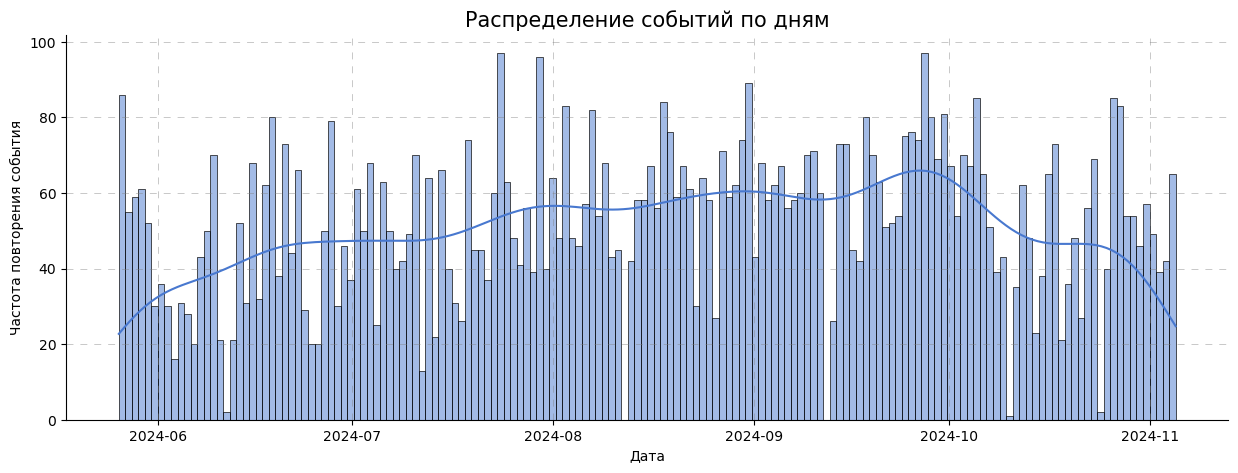

In [59]:
# распределение значений столбца created_at
plt.figure(figsize=(15,5))
sns.histplot(data = data, x = 'event_date', kde = True, bins = 162)

plt.title('Распределение событий по дням', fontsize=15)
plt.xlabel('Дата')
plt.ylabel('Частота повторения события')

plt.grid(color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)
sns.despine() # удаление рамки

plt.show()

Гистограмма показывает распределение событий во времени по дням. Иногда события вовсе отсутствуют.

Посмотрим, как события распределены между месяцами:

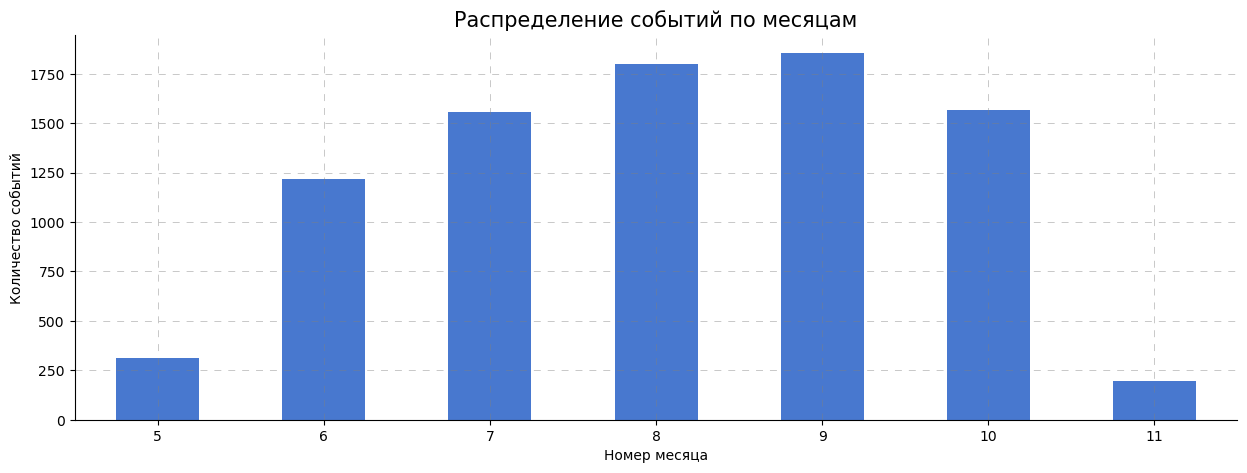

In [61]:
# столбчатая диаграмма 
data.groupby('event_month').agg({'coordinate': 'count'}).plot(kind = 'bar', figsize = (15, 5), legend=False)

plt.title('Распределение событий по месяцам', fontsize=15)
plt.xlabel('Номер месяца')
plt.ylabel('Количество событий')
plt.xticks(rotation = 0)

plt.grid(color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)
sns.despine()

plt.show()

Диаграмма подтверждает, что за май и ноябрь данные не полные. Посмотрим в процентном соотношении:

In [63]:
# число событий по месяцам в абсолютном и процентном выражении
events_by_month = data.pivot_table(index = 'event_month', values = 'coordinate', aggfunc = 'count')
events_by_month.columns = ['count_of_events']
events_by_month['% of total']= round(events_by_month['count_of_events'] / events_by_month['count_of_events'].sum() * 100, 0)
events_by_month

count_of_events  % of total
event_month                             
5                        313         4.0
6                       1218        14.0
7                       1558        18.0
8                       1800        21.0
9                       1854        22.0
10                      1564        18.0
11                       195         2.0

Пик событий приходится на сентябрь и август (22 % и 21 % от общего числа событий соответственно). По 18 % событий приходится на июль и октябрь. 

Посмотрим на значения среднего и медианы числа событий:

In [65]:
print('Среднее число событий в месяц:', round(events_by_month['count_of_events'].mean()))
print('Медианное число событий в месяц:', round(events_by_month['count_of_events'].median()))

Среднее число событий в месяц: 1215
Медианное число событий в месяц: 1558


Разрыв между медианой и средним объясняется отсутствием большей части данных за май (96 %) и ноябрь (98 %). Фактически имеем, что в май попало 5 суток, в ноябрь - 6 суток. 

Вычислим длительность временных интервалов, для того, чтобы оценить, сколько в среднем времени в день Ириска проводит на улице.

Для этого сначала посчитаем разницу между временем текущего дня и временем предыдущего дня:

In [67]:
time_df = data[['event_date', 'created_at']].sort_values(by = 'created_at').reset_index(drop=True)

# смещение на одно значение назад
time_df['time_lag'] = time_df['created_at'].shift(1)

# разница между текущим и новым значением со смещением
time_df['time_diff'] = time_df['created_at'] - time_df['time_lag']

# замена NaT на 0
time_df = time_df.fillna('0')
time_df.head()

event_date          created_at             time_lag       time_diff
0 2024-05-26 2024-05-26 17:05:22                    0 0 days 00:00:00
1 2024-05-26 2024-05-26 17:06:13  2024-05-26 17:05:22 0 days 00:00:51
2 2024-05-26 2024-05-26 17:08:09  2024-05-26 17:06:13 0 days 00:01:56
3 2024-05-26 2024-05-26 17:10:41  2024-05-26 17:08:09 0 days 00:02:32
4 2024-05-26 2024-05-26 17:16:42  2024-05-26 17:10:41 0 days 00:06:01

In [68]:
# time_diff в секундах
time_df['time_diff_sec'] = time_df['time_diff'] / np.timedelta64(1, 's')

display(time_df.sample(n=3))

time_df.describe().T

event_date          created_at             time_lag       time_diff  \
6466 2024-09-27 2024-09-27 12:04:38  2024-09-27 12:03:41 0 days 00:00:57   
3765 2024-08-13 2024-08-13 20:04:17  2024-08-13 19:59:12 0 days 00:05:05   
8405 2024-11-03 2024-11-03 03:56:04  2024-11-03 03:36:03 0 days 00:20:01   

      time_diff_sec  
6466           57.0  
3765          305.0  
8405         1201.0

count                           mean                  min  \
event_date       8502  2024-08-18 19:27:28.835568128  2024-05-26 00:00:00   
created_at       8502  2024-08-19 08:21:06.382498304  2024-05-26 17:05:22   
time_diff        8502      0 days 00:27:32.728416843      0 days 00:00:00   
time_diff_sec  8502.0                    1652.728417                  0.0   

                                         25%                         50%  \
event_date               2024-07-13 00:00:00         2024-08-21 00:00:00   
created_at     2024-07-13 10:53:13.249999872  2024-08-21 06:40:57.500000   
time_diff                    0 days 00:09:59             0 days 00:10:11   
time_diff_sec                          599.0                       611.0   

                                         75%                  max  \
event_date               2024-09-26 00:00:00  2024-11-05 00:00:00   
created_at     2024-09-26 15:57:32.750000128  2024-11-05 08:16:59   
time_diff                    0 days 00:20:00      1 days 21:09:06   
time_diff_sec                         1200.0             162546.0   

                                     std  
event_date                           NaN  
created_at                           NaN  
time_diff      0 days 01:29:50.507993451  
time_diff_sec                5390.507993

В среднем (по медиане) событие в логе происходит каждые 10 минут (611 сек). Это значение задается пользователем в личном кабинете и подтверждает обещания продавца услуг.

Однако, среднее арифметическое значение диапазона *time_diff* - 28 минут (1653 сек). Причинами этой разницы очевидно являются выбросы, например, такие как максимальное значение 1 день 21 час - что-то невероятное. 

Попробуем разобраться, с чем могут быть связаны такие длительные диапазоны, и какие диапазоны следует считать длительными.

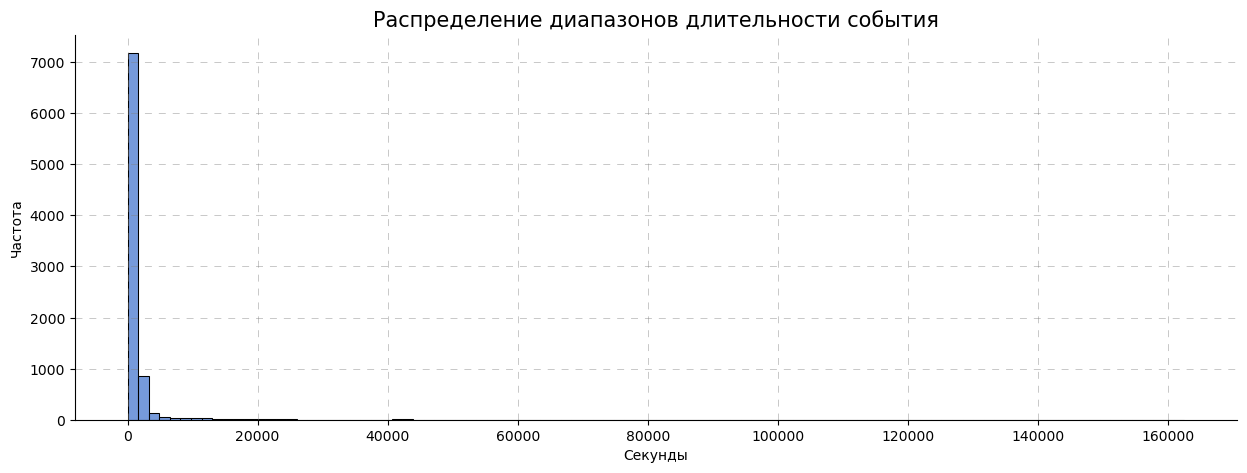

In [70]:
# распределение значений столбца интервал времени, секунды
plt.figure(figsize=(15,5))
sns.histplot(time_df, x = 'time_diff_sec', kde = False, bins = 100)

plt.title('Распределение диапазонов длительности события', fontsize=15)
plt.xlabel('Секунды')
plt.ylabel('Частота')

plt.grid(color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)
sns.despine() 

plt.show()

Большинство значений укладываются в диапазоне ~ 1000 - 2000 секунд. Данные смещены вправо, на что указывает длинный "незаметный" хвост. Посмотрим на ящик с усами, чтобы нагляднее увидеть выбросы:

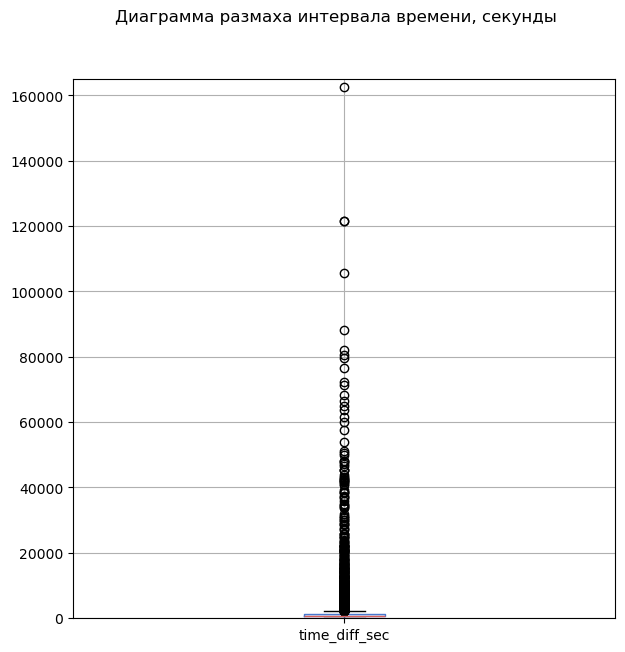

In [72]:
# ящик с усами интервал времени, секунды
time_df.boxplot('time_diff_sec', figsize = (7, 7))
plt.ylim(-1.0, 165000)
plt.suptitle('Диаграмма размаха интервала времени, секунды')
plt.show()

Из-за широкого разброса данных наблюдаем в основном выбросы. Определим границы интервала наиболее вероятных значений:

In [74]:
q1 = time_df['time_diff_sec'].quantile(0.25) # расчет значения первого квартиля
q3 = time_df['time_diff_sec'].quantile(0.75) # расчет значения третьего квартиля

iqr = q3 - q1 # межквартильный размах

print(f'Границы интервала наиболее вероятных значений: {q1 - 1.5 * iqr, q3 + 1.5 * iqr}') 
print('Фактическое значение нижней границы:', time_df['time_diff_sec'].min())
print('Количество выбросов:', time_df.query('time_diff_sec > @ q3 + 1.5 * @ iqr | time_diff_sec < @ q1 - 1.5 * @ iqr')['time_diff_sec'].count())
print()
print('Топ-5 выбросов, секунды:')
time_df.query('time_diff_sec > @ q3 + 1.5 * @ iqr | time_diff_sec < @ q1 - 1.5 * @ iqr')['time_diff_sec'].sort_values(ascending=False).head()

Границы интервала наиболее вероятных значений: (-302.5, 2101.5)
Фактическое значение нижней границы: 0.0
Количество выбросов: 802

Топ-5 выбросов, секунды:


5562    162546.0
3727    121709.0
7888    121430.0
7285    105775.0
7650     88262.0
Name: time_diff_sec, dtype: float64

Отберем значения, входящие в границы интервала наиболее вероятных значений:

In [76]:
time_df = time_df.query('time_diff_sec <= @ q3 + 1.5 * @ iqr & time_diff_sec >= @ q1 - 1.5 * @ iqr')

# число строк после удаления выбросов
time_df.shape[0]

7700

С выбросами теряется 9.5 % значений. 

В идеале каждое значение t_diff должно быть равно 10 минутам, так как события записываются в файл именно с этой периодичностью. Что и было подтверждено медианным значением (611 секунд). Трекер неактивен в состоянии покоя и в помещениях. Сдедовательно, во время этих длительных промежутков времени кошка либо была дома, либо дремала на улице. Либо, не шевелясь, познавала окружающий мир. 

Чтобы не терять еще больше данных, верхней границей примем значение 2100 секунд (35 минут).

Посмотрим, как теперь распределены данные:

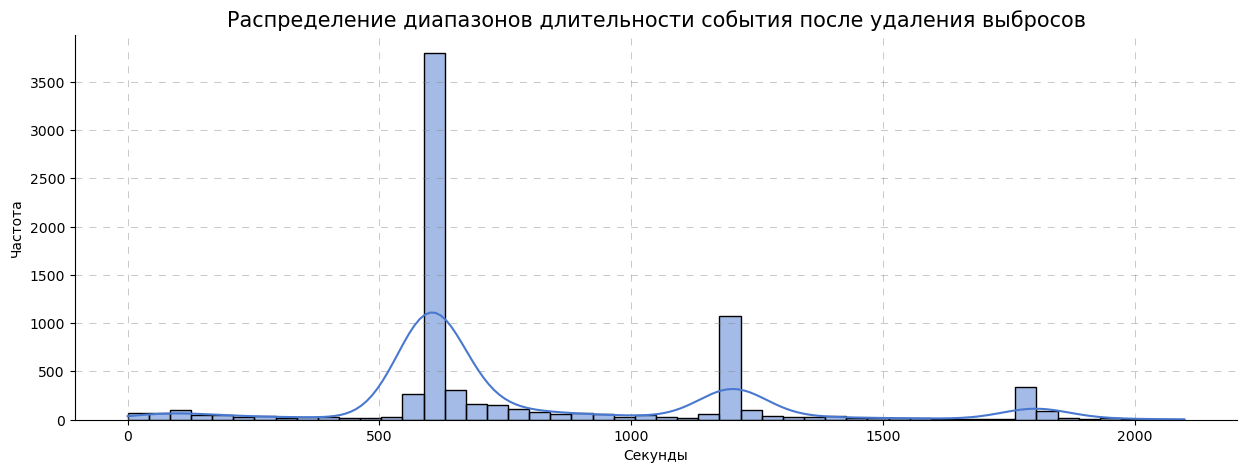

In [78]:
# распределение значений столбца интервал времени, секунды
plt.figure(figsize=(15,5))
sns.histplot(time_df, x = 'time_diff_sec', kde = True, bins = 50)

plt.title('Распределение диапазонов длительности события после удаления выбросов', fontsize=15)
plt.xlabel('Секунды')
plt.ylabel('Частота')

plt.grid(color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)
sns.despine() 

plt.show()

In [79]:
time_df.describe().T

count                           mean                  min  \
event_date       7700  2024-08-19 12:00:44.883117056  2024-05-26 00:00:00   
created_at       7700  2024-08-20 00:58:50.380389632  2024-05-26 17:05:22   
time_diff        7700      0 days 00:13:18.314675324      0 days 00:00:00   
time_diff_sec  7700.0                     798.314675                  0.0   

                                         25%                  50%  \
event_date               2024-07-15 00:00:00  2024-08-22 00:00:00   
created_at     2024-07-15 12:32:01.750000128  2024-08-22 03:13:01   
time_diff                    0 days 00:09:59      0 days 00:10:05   
time_diff_sec                          599.0                605.0   

                                         75%                  max  \
event_date               2024-09-26 00:00:00  2024-11-05 00:00:00   
created_at     2024-09-26 19:43:04.750000128  2024-11-05 08:16:59   
time_diff                    0 days 00:19:29      0 days 00:34:58   
time_diff_sec                         1169.0               2098.0   

                                     std  
event_date                           NaN  
created_at                           NaN  
time_diff      0 days 00:06:35.207415778  
time_diff_sec                 395.207416

Значения левее основного пика могут быть связаны с экстренным поиском по запросу пользователя.

Основной пик приходится на 600 секунд (10 минут), остальные на 20 и 30 минут в порядке убывания соответственно.

Разрыв между значениями медианы и среднего сократился примерно а два раза, однако еще сложно сказать, что значения теперь равны. Это говорит о еще оставшихся выбросах. Имеем это в виду и идем дальше.

Посчитаем, сколько секунд суммарно кошка проводит на улице по дням:

In [81]:
# суммарное время проведенное на улице по дням, секунды
time_sum = time_df.pivot_table(index = 'event_date', values = 'time_diff_sec', aggfunc= 'sum').sort_values('event_date')
time_sum.sample(n=3)

time_diff_sec
event_date               
2024-10-09        34496.0
2024-06-03        25419.0
2024-08-23        18764.0

Добавим столбец с временем в часах:

In [83]:
# суммарное время проведенное на улице по дням в часах
time_sum['time_diff_h'] = round(time_sum['time_diff_sec'] / 3600)
time_sum.sample(n=1)

time_diff_sec  time_diff_h
event_date                            
2024-06-29        19608.0          5.0

In [84]:
time_sum.describe().T

count          mean           std     min      25%      50%  \
time_diff_sec  159.0  38660.522013  14463.229589  8509.0  28912.5  38429.0   
time_diff_h    159.0     10.735849      4.075945     2.0      8.0     11.0   

                   75%      max  
time_diff_sec  48836.0  75174.0  
time_diff_h       14.0     21.0

После удаления выбросов осталось 159 дней наблюдений.

В среднем кошка проводит на улице ~ 11 часов в день.

В 75 % случаев прогулка длится около 14 часов.

Посмотрим, как распределяются данные: 

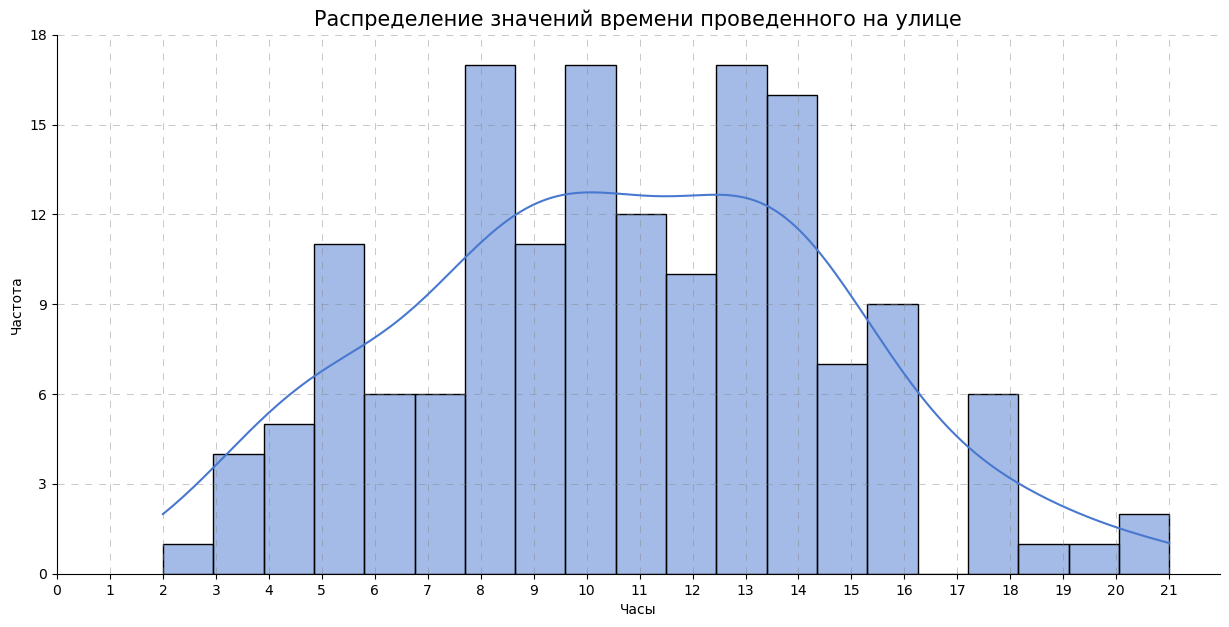

In [86]:
# суммарное проведенное  время на улице по часам (округление до целого)
plt.figure(figsize=(15,7))
sns.histplot(time_sum, x = 'time_diff_h', kde = True, bins = 20)

plt.title('Распределение значений времени проведенного на улице', fontsize=15)
plt.xlabel('Часы')
plt.ylabel('Частота')
plt.xticks(np.arange(0, 22, 1))
plt.yticks(np.arange(0, 20, 3))

plt.grid(color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)
sns.despine() 

plt.show()

Из гистограммы частот следует, что наиболее часто в данных встречаются такие значения, как 8,10 и 11 часов.

Добавим полученные данные к основному датасету:

In [88]:
# сброс индекса для дальнейшего объединения таблиц
time_sum = time_sum.reset_index()
time_sum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   event_date     159 non-null    datetime64[ns]
 1   time_diff_sec  159 non-null    float64       
 2   time_diff_h    159 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 3.9 KB


In [89]:
# добавление к основному датасету информации о времени
data = data.merge(time_sum, on = 'event_date', how='inner')

display(data.sample(n=1))
data.shape[0]

coordinate          created_at type  accuracy  extra_search  \
6739  55.86046833, 38.65234 2024-09-29 15:56:13  gps        10         False   

      direction  event_month event_date event_time  event_hour   latitude  \
6739        149            9 2024-09-29   15:56:13          15  55.860468   

      longitude  time_diff_sec  time_diff_h  
6739   38.65234        52794.0         15.0

8497

In [90]:
data['event_date'].nunique()

159

Данные объединены верно, в основном датасете осталось 159 уникальных дней и 8497 строк.

#### Промежуточные выводы

После удаления выбросов остались данные за 159 дней (8497 строк).

В среднем в сутки кошка проводит ~ 11 часов на улице. В 75 % наблюдений длительность пребывания составляет ~ 14 часов.

Наиболее часто среди времени прогулки встречаются такие значения, как 8,10 и 11 часов.

### Кнопка Экстренный поиск

Режим экстренного поиска включается вручную в мобильном приложении, чтобы быстрее найти питомца. При этом координаты передаются на телефон каждые 20−30 секунд, а не каждые 10 минут. Значение 10 минут тоже настраивается хозяином в приложении, для экономии заряда можно установить 20 минут и реже.

In [96]:
# уникальные значения и их встречаемость в столбце Экстренный поиск
data['extra_search'].value_counts()

extra_search
False    8022
True      475
Name: count, dtype: int64

In [97]:
print('Режим экстренного поиска включался в', round(data.query('extra_search == True')['extra_search'].count() / data['extra_search'].count() * 100, 1), '% случаев от общего')

Режим экстренного поиска включался в 5.6 % случаев от общего


В столбце *extra_search* в основном встречаются значения False (94.4 %).

Таким образом, как минимум, 475 раз я переживала за безопасность своей кошки за полгода использования трекера.

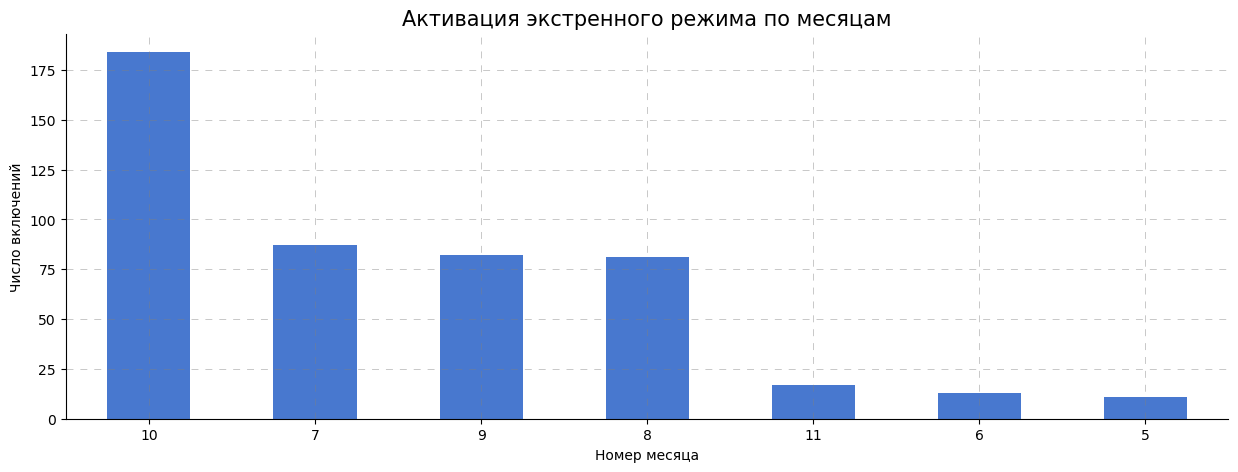

In [99]:
# активация экстренного режима по месяцам
[data
.query('extra_search == True')
.groupby('event_month')['extra_search']
.count()
.sort_values(ascending = False)
.plot(
    kind='bar',
    figsize = (15, 5),
    legend=False
)]

plt.title('Активация экстренного режима по месяцам', fontsize=15)
plt.xlabel('Номер месяца')
plt.ylabel('Число включений')
plt.xticks(rotation = 0)

plt.grid(color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)
sns.despine()

plt.show()

In [100]:
# активация экстренного режима по месяцам
data.query('extra_search == True').groupby('event_month')['extra_search'].count().sort_values(ascending = False)

event_month
10    184
7      87
9      82
8      81
11     17
6      13
5      11
Name: extra_search, dtype: int64

Чаще всего экстренный режим включался в октябре. Определим даты с наибольшим числом включений экстренного режима:

In [102]:
# дата активации экстренного режима - число включений режима (топ-5)
data.query('extra_search == True').groupby('event_date')['extra_search'].count().sort_values(ascending = False).head()

event_date
2024-10-31    29
2024-10-13    24
2024-10-04    24
2024-10-23    20
2024-10-06    19
Name: extra_search, dtype: int64

Весь топ-5 приходится на октябрь. На мой взгляд, именно в октябре Ириска стала уходить дальше от дома и глубже в лес. 

Отберем данные за 31 октября с включенным экстренным режимом:

In [104]:
# день с максимальным числом включения кнопки экстренного поиска
max_extra_search = data.query('created_at >= "2024-10-31 00:00:00" and created_at < "2024-11-01 00:00:00"').sort_values(by = 'created_at')
max_extra_search.tail()

coordinate          created_at type  accuracy  \
8309  55.85603833, 38.65090667 2024-10-31 22:01:33  gps        10   
8310  55.85581833, 38.65070667 2024-10-31 22:16:25  gps        10   
8311     55.85605667, 38.65063 2024-10-31 22:23:13  gps        10   
8312  55.85599833, 38.65076833 2024-10-31 22:33:01  gps        10   
8313    55.856115, 38.65079111 2024-10-31 22:34:04  gps        10   

      extra_search  direction  event_month event_date event_time  event_hour  \
8309          True        108           10 2024-10-31   22:01:33          22   
8310          True         22           10 2024-10-31   22:16:25          22   
8311          True         44           10 2024-10-31   22:23:13          22   
8312          True        244           10 2024-10-31   22:33:01          22   
8313         False        123           10 2024-10-31   22:34:04          22   

       latitude  longitude  time_diff_sec  time_diff_h  
8309  55.856038  38.650907        27653.0          8.0  
8310  55.855818  38.650707        27653.0          8.0  
8311  55.856057  38.650630        27653.0          8.0  
8312  55.855998  38.650768        27653.0          8.0  
8313  55.856115  38.650791        27653.0          8.0

In [105]:
# перемещения 31-10-2024 только при включенном экстренном поиске
max_extra_search = max_extra_search.query('extra_search == True')

In [106]:
# перемещения животного 31 октября при включенном экстренном поиске
dual_map = DualMap(location=(55.85634, 38.65033), zoom_start=20)

for latitude, longitude, time in zip(max_extra_search['latitude'], max_extra_search['longitude'], max_extra_search['event_time']):
    folium.Marker(
        location=[latitude, longitude],
        tooltip = "click me!",
        popup=time,
        icon=folium.Icon(color = 'green')
    ).add_to(dual_map.m1)

# antpath (тропа муравья)
coordinates = [
    zip(max_extra_search['latitude'], max_extra_search['longitude'])
]

folium.plugins.AntPath(
    locations=coordinates,
    reverse=False,
    dash_array=[20, 30]
).add_to(dual_map.m2)

dual_map.m2.fit_bounds(dual_map.m2.get_bounds())
folium.LayerControl().add_to(dual_map)

dual_map

Глядя на карту, я сразу вспомнила тот день =)  Ириска предпочитает леса, но в этот раз впервые направилась в сторону дорожной трассы. В тот вечер её привлекли подстриженные кусты соседей и часовня деревни, где она провела весь вечер.

#### Промежуточные выводы

Режим экстренного поиска включался в 5.6 % случаев от общего числа событий.

Чаще всего в октябре - 184 раза (в ~ 39 % случаев от общего extra search). Это связано с моим беспокойством за безопасность питомца. По субъективным ощущениям прогулки Ириски стали дальше от дома - в сторону лесов.

Визуализированы перемщения питомца в день максимального числа включений режима экстренного поиска с самым нетипичным маршрутом - наиболее близкое приближение к дорожной трассе.

### Расчет и визуализация границ и площади территории прогулок питомца

Определим границы и площадь участка, по которому перемещается домашняя кошка. Для этого найдем наиболее отдаленные точки:

In [112]:
# наибольшее / наименьшее значение среди значений долготы
data[(data['longitude'] == data['longitude'].max()) | (data['longitude'] == data['longitude'].min())]

coordinate          created_at type  accuracy  \
6851  55.86277333, 38.66767333 2024-09-30 22:13:23  gps        10   
8087      55.86616944, 38.6433 2024-10-27 18:21:36  gps        10   

      extra_search  direction  event_month event_date event_time  event_hour  \
6851         False        294            9 2024-09-30   22:13:23          22   
8087         False         14           10 2024-10-27   18:21:36          18   

       latitude  longitude  time_diff_sec  time_diff_h  
6851  55.862773  38.667673        52757.0         15.0  
8087  55.866169  38.643300        57768.0         16.0

In [113]:
# наибольшее / наименьшее значение среди значений широты
data[(data['latitude'] == data['latitude'].max()) | (data['latitude'] == data['latitude'].min())]

coordinate          created_at type  accuracy  \
7453  55.87267833, 38.65799167 2024-10-12 18:59:05  gps        10   
8314    55.855425, 38.65147833 2024-11-01 00:14:17  gps        10   

      extra_search  direction  event_month event_date event_time  event_hour  \
7453         False        211           10 2024-10-12   18:59:05          18   
8314         False        257           11 2024-11-01   00:14:17           0   

       latitude  longitude  time_diff_sec  time_diff_h  
7453  55.872678  38.657992        38946.0         11.0  
8314  55.855425  38.651478        22329.0          6.0

Визуализируем полученные координаты, которые становятся вершинами четырехугольника, площадь которого и захватит все перемещения питомца. Для удобства назовем вершины по сторонам света (север / юг / запад / восток):

In [115]:
# область, в пределах которой перемещается Ириска
total_area = folium.Map(location=loc_center, zoom_start=14)

locations = [
    [55.86277333, 38.66767333],
    [55.87267833, 38.65799167],
    [55.86616944, 38.6433],
    [55.855425, 38.65147833]
]



folium.Polygon(
    locations=locations,
    color="green",
    weight=5,
    fill_color="pink",
    fill_opacity=0.4,
    fill=True,
    popup="Границы прогулок",
    tooltip="Click me!",
).add_to(total_area)


folium.Marker(
    location=loc_center, 
    tooltip="Click me!",
    popup="home",
    icon=folium.Icon(icon="home"),
).add_to(total_area)


folium.Marker(
    location=[55.86277333, 38.66767333], 
    tooltip="A (восток)",
    popup=[55.86277333, 38.66767333],
    icon=folium.Icon(icon="glyphicon-tree-conifer", color='green'),
).add_to(total_area)


folium.Marker(
    location=[55.87267833, 38.65799167], 
    tooltip="B (север)",
    popup=[55.87267833, 38.65799167],
    icon=folium.Icon(icon="glyphicon-tree-conifer", color='green'),
).add_to(total_area)


folium.Marker(
    location=[55.86616944, 38.6433], 
    tooltip="C (запад)",
    popup=[55.86616944, 38.6433],
    icon=folium.Icon(icon="glyphicon-tree-conifer", color='green'),
).add_to(total_area)

folium.Marker(
    location=[55.855425, 38.65147833], 
    tooltip="E (юг)",
    popup=[55.855425, 38.65147833],
    icon=folium.Icon(icon="glyphicon-road", color='green'),
).add_to(total_area)


total_area

Чтобы определить площадь неправильного четырехугольника ABCE необходимо знать диагонали фигуры и угол между ними.

In [117]:
a = np.array([55.86277333, 38.66767333])    # восток
b = np.array([55.87267833, 38.65799167])    # север
c = np.array([55.86616944, 38.6433])        # запад
e = np.array([55.855425, 38.65147833])      # юг

Диагонали d1 и d2 определим с помощью библиотеки geopy модуля distance:

In [119]:
# геодезическое расстояние между точками c и a (запад-восток)
d1 = geodesic(c, a).kilometers

# геодезическое расстояние между точками b и e (север-юг)
d2 = geodesic(b, e).kilometers

print('Геодезическое расстояние между крайней западной и восточной точками:', round(d1, 3), 'километров')
print('Геодезическое расстояние между крайней северной и южной точками:', round(d2, 3), 'километров')

Геодезическое расстояние между крайней западной и восточной точками: 1.572 километров
Геодезическое расстояние между крайней северной и южной точками: 1.964 километров


Геодезическое расстояние - это кратчайшее расстояние на поверхности эллипсоидальной модели Земли. По умолчанию в geopy используется эллипсоид WGS-84.

Для расчета угла между диагоналями d1 и d2 воспользуемся библиотекой numpy и основами линейной алгебры. Косинус угла между векторами рассчитывается как отношение скалярного произведения векторов к произведению норм векторов:

In [121]:
# определение координат каждого вектора (из координат конца вычитаются координаты начала)
ac = c - a   # d1
be = e - b   # d2

# скалярное произведение векторов / нормы векторов
cos_angle = ac @ be / norm(ac) / norm(be) # евклидова норма по умолчанию

# арккосинус в радианах
angle = np.arccos(cos_angle)

# вывод косинуса
print('Косинус угла между d1 и d2:', cos_angle)

# вывод угла в градусах
print('Угол:', round(np.rad2deg(angle)), '°')

Косинус угла между d1 и d2: 0.22069348991396218
Угол: 77 °


Неважно какой из двух углов при пересечении диагоналей будет выбран, результат будет неизменен.

Рассчитаем площадь четырехугольника, как полупроизведение диагоналей на синус угла между ними:

In [123]:
# площадь перемещения питомца, км^2
quadrangle_area = (d1 * d2 * np.sin(np.rad2deg(angle))) / 2
print('Площадь участка прогулок Ириски:', round(quadrangle_area, 2), 'квадр.км')

Площадь участка прогулок Ириски: 1.48 квадр.км


В научной статье [https://pmc.ncbi.nlm.nih.gov/articles/PMC5789300/] авторы утверждают, что для потерявшихся домашних кошек, регулярно имеющих доступ на улицу, радиус успешного поиска может составлять 2 и более километров.

#### Промежуточные выводы

Определены и визуализированы границы прогулок питомца. Максимальное геодезическое расстояние между крайней северной и южной точками составляет ~ 2.0 км, а между западной и восточной ~ 1.6 км.

Площадь территории прогулок питомца ~ 1.5 км^2.

### Столбец *direction*

Посмотрим на значения, содержащиеся в столбце *Направление*:

In [129]:
# уникальные значения и их встречаемость в столбце Направление
data['direction'].value_counts()

direction
17     40
144    39
308    38
302    37
8      36
       ..
177    14
291    13
265    13
60     13
134    12
Name: count, Length: 360, dtype: int64

In [130]:
data['direction'].describe().T

count    8497.000000
mean      179.180887
std       105.140946
min         0.000000
25%        89.000000
50%       178.000000
75%       271.000000
max       359.000000
Name: direction, dtype: float64

Значения в столбце *direction* представлены от 0 до 359 включительно. Медиана и среднее примерно равны, что говорит об отсутствии резко выбиващихся значений.

Пока не совсем ясно, что за данные содержатся в этом столбце. Исходя из числового типа int, может быть это метры? Значение 359 похоже на градусы направления по сторонам света.

Посмотрим, как распределены данные:

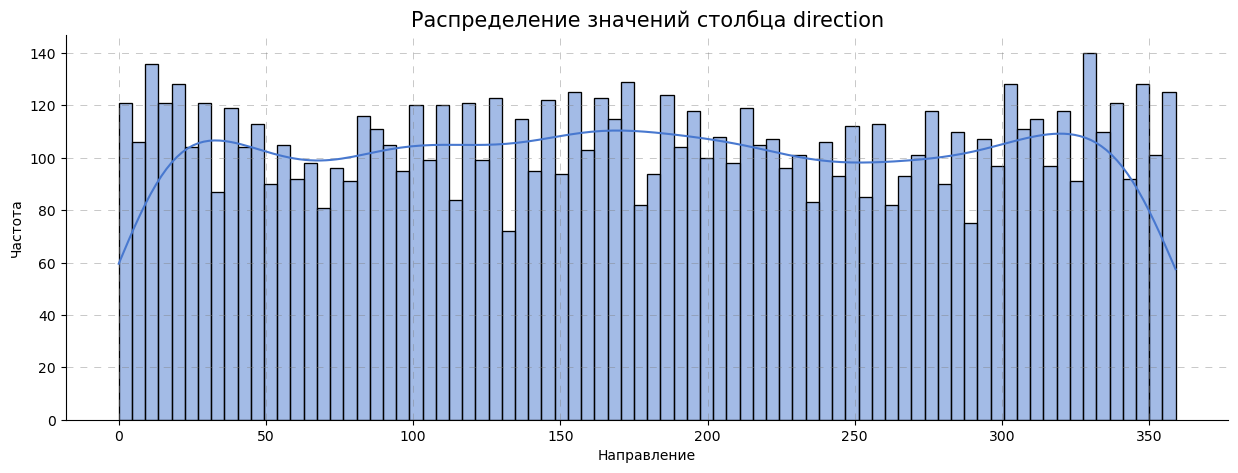

In [132]:
# гистрограмма частот по столбцу Направление
plt.figure(figsize=(15,5))
sns.histplot(data = data, x = 'direction', kde = True, bins = 80)

plt.title('Распределение значений столбца direction', fontsize=15)
plt.xlabel('Направление')
plt.ylabel('Частота')

plt.grid(color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)
sns.despine() 

plt.show()

Данные распределены равномерно, то есть каждое из этих значений реализуется с одинаковой вероятностью. Будем считать, что в столбце *direction* содержится информация о направлении в градусах (измерения от севера текущего положения к востоку). Вероятно, значение рассчитывается с использованием предыдущих координат положения.

Напишем функцию, позволяющую сегментировать значения из столбца по сторонам света:

In [134]:
def cardinal_directions(degree):
    """
    Принимает на вход:
    - degree - значение градуса из столбца *direction*
        
    Возвращает направление стороны света, используя правила:
    - 'северо-восток' — если значение градуса между 1 и 89 включительно;
    - 'юго-восток', если значение градуса между 91 и 179 включительно;
    - 'юго-запад', если значение градуса между 181 и 269 включительно;
    - 'северо-запад' — если значение градуса между 271 и 359 включительно;
    - 'север' - если значение градуса строго равно 0;
    - 'восток' - если значение градуса строго равно 90;
    - 'юг' - если значение градуса строго равно 180;
    - 'запад' - во всех остальных случаях, то есть строго 270.
    """
        
    if 1 <= degree <= 89:
        return 'северо-восток'
    elif 91 <= degree <= 179:
        return 'юго-восток'
    elif 181 <= degree <= 269:
        return 'юго-запад'
    elif 271 <= degree <= 359:
        return 'северо-запад'
    elif degree == 0:
        return 'север' 
    elif degree == 90:
        return 'восток'
    elif degree == 180:
        return 'юг'  
    else:
        return 'запад'

In [135]:
# вызов функции
data['part_of_the_world'] = data['direction'].apply(cardinal_directions)

data.sample(n=3)

coordinate          created_at type  accuracy  \
6612  55.86186333, 38.65158833 2024-09-27 16:37:13  gps        10   
1955    55.862475, 38.65087667 2024-06-29 19:03:36  gps        10   
5821    55.86328167, 38.653955 2024-09-14 21:33:59  gps        10   

      extra_search  direction  event_month event_date event_time  event_hour  \
6612         False        256            9 2024-09-27   16:37:13          16   
1955         False        333            6 2024-06-29   19:03:36          19   
5821         False         27            9 2024-09-14   21:33:59          21   

       latitude  longitude  time_diff_sec  time_diff_h part_of_the_world  
6612  55.861863  38.651588        75174.0         21.0         юго-запад  
1955  55.862475  38.650877        19608.0          5.0      северо-запад  
5821  55.863282  38.653955        57151.0         16.0     северо-восток

In [136]:
# направление сторон света в абсолютном и процентном выражении
side_world = data.groupby('part_of_the_world').agg({'coordinate': 'count'})
side_world.columns = ['count']
side_world['% of total'] = round(side_world['count'] / side_world['count'].sum() * 100, 1)
side_world.sort_values(by = '% of total', ascending=False)

count  % of total
part_of_the_world                   
северо-запад        2148        25.3
юго-восток          2121        25.0
северо-восток       2115        24.9
юго-запад           2012        23.7
запад                 27         0.3
север                 25         0.3
юг                    29         0.3
восток                20         0.2

Данные примерно равномерно распределены между 4-мя секторами: 
- северо-запад
- юго-восток
- северо-восток
- юго-запад.

Разделение на 8 категорий, вероятно, не требовалось. На каждую сторону света приходится по четвети всех данных.

In [138]:
# сводная таблица
exsearch_pivot = data.pivot_table(index ='part_of_the_world', columns = 'extra_search', values = 'direction', aggfunc = 'count')
exsearch_pivot.columns = ['false', 'true']

# процент true от общего
exsearch_pivot['true, %'] = round(exsearch_pivot['true'] / (exsearch_pivot['true'] + exsearch_pivot['false']) * 100, 1)
exsearch_pivot = exsearch_pivot.fillna(0).sort_values(by = 'false', ascending=False)
exsearch_pivot

false   true  true, %
part_of_the_world                        
северо-запад       2048.0  100.0      4.7
юго-восток         2003.0  118.0      5.6
северо-восток      1989.0  126.0      6.0
юго-запад          1883.0  129.0      6.4
юг                   29.0    0.0      0.0
запад                25.0    2.0      7.4
север                25.0    0.0      0.0
восток               20.0    0.0      0.0

#### Промежуточные выводы

*direction* принимает значения от 0 до 359.

Принимаем, что в столбце содержится информация об угле направления движения, измеряемом в градусах от севера к востоку.

Возможно, направление движения рассчитано на основе двух последовательных GPS-точек.

### Широта и долгота

Посмотрим, как распределяются данные столбцов с географическими координатами:

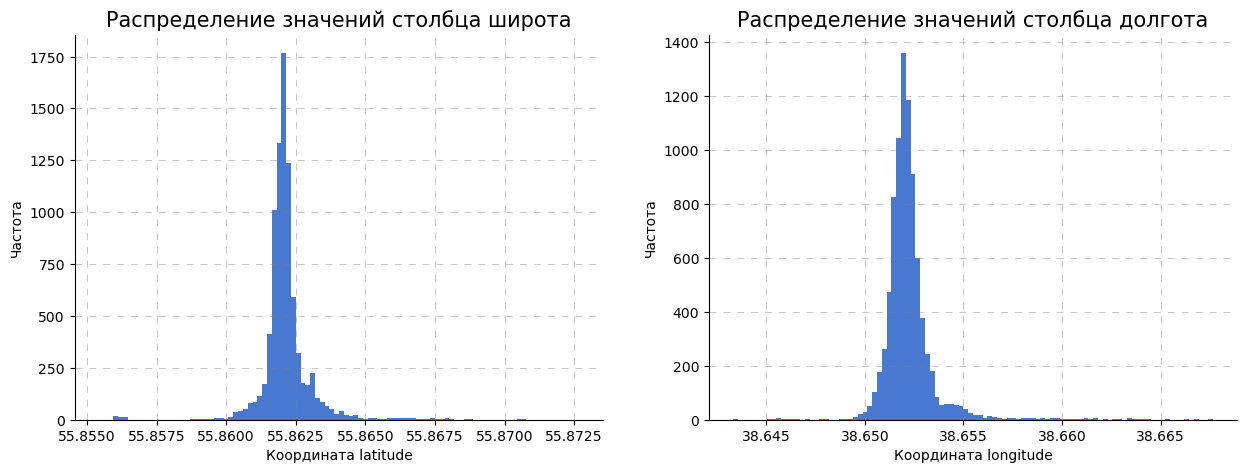

In [143]:
# гистрограмма по столбцу широта
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1) # в одной строке два графика, этот - первый
plt.hist(data['latitude'], bins = 100,)
plt.title('Распределение значений столбца широта', fontsize=15)
plt.xlabel('Координата latitude')
plt.ylabel('Частота')

plt.grid(color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)
sns.despine() 

# гистрограмма по столбцу долгота
plt.subplot(1, 2, 2) # в одной строке два графика, этот - второй
plt.hist(data['longitude'], bins = 100,)
plt.title('Распределение значений столбца долгота', fontsize=15)
plt.xlabel('Координата longitude')
plt.ylabel('Частота')

plt.grid(color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)
sns.despine() 

plt.show()

В обоих случаях данные распределены нормально.

Визуализируем их, используя библиотеку plotly:

In [145]:
# диаграмма рассеивания широта - долгота за все время наблюдений
scatter_fig1 = px.scatter(data, x='latitude', y='longitude')
scatter_fig1.update_xaxes(showgrid=False)
scatter_fig1.update_yaxes(showgrid=False)
scatter_fig1.update_layout(plot_bgcolor='white')
scatter_fig1.show()

Основная масса точек сосредоточена в диапазоне ~ 55.861 - 55.863 / ~ 38.65 - 38.655. Есть и совсем пустые зоны. 

Едва ли по полученной диаграмме можно определить наличие корреляции между широтой и долготой. При этом в правой части диаграммы с увеличением широты с 55.866 увеличивается и долгота. 

Посмотрим на данные ближе - может все таки в них имеется тренд?

In [147]:
# увеличение масштаба разброса. широта >= 55.866
scatter_fig2 = px.scatter(data.query('latitude >= 55.866'), x='latitude', y='longitude', trendline="ols", trendline_color_override="red")
scatter_fig2.update_xaxes(showgrid=False)
scatter_fig2.update_yaxes(showgrid=False)
scatter_fig2.update_layout(plot_bgcolor='white')
scatter_fig2.show()

Выборочный коэффициент дерерминации получился равным 0.73. То есть 73 % всей дисперсии исходного набора данных описывается построенной линейной регрессией. Это говорит о наличии достаточно сильной линейной связи между широтой и долготой на этом участке.

Добавим к основной диаграмме рассеяния третью ось  - месяц:

In [149]:
# 3d диаграмма рассеяния широта-долгота по месяцам
scatter_fig3 = px.scatter_3d(data, x='latitude', y='longitude', z='event_month', color='event_month')
scatter_fig3.update_traces(marker=dict(size=2), selector=dict(mode='markers'))
scatter_fig3
scatter_fig3.show()

Основной вывод, который можно сделать из сложной пространственной диаграммы - с сентября кошка стала удаляться во время прогулок все дальше от дома. Это можно связать, например, с ее взрослением.

Добавляют ли подобные сложные графики какую-либо аналитическую ценность проекту - противоречивый вопрос, однако выглядят они эффектно.

#### Промежуточные выводы

Питомец чаще всего гуляет в зоне ~ 55.861 - 55.863 / ~ 38.65 - 38.655.

Однако, с сентября маршруты стали менее предсказуемыми — кошка начала выходить за границы привычной территории.

### Heatmaps

#### HeatMapWithTime

Построим тепловую карту во времени - анимируем данные перемещения в интервале 26.05.2024 - 5.11.2024. 

Объединим необходимые данные в *heatmaptime_df*:

In [156]:
# датафрейм с датой, широтой, долготой
heatmaptime_df = data[['event_date', 'latitude', 'longitude']]
heatmaptime_df.sample(n=1)

event_date   latitude  longitude
4028 2024-08-11  55.861837   38.65185

В качестве индекса используем диапазон дат:

In [158]:
# индекс - диапазон уникальных дат
time_index = list(heatmaptime_df['event_date'].sort_values().astype('str').unique())
time_index

['2024-05-26',
 '2024-05-27',
 '2024-05-28',
 '2024-05-29',
 '2024-05-30',
 '2024-05-31',
 '2024-06-01',
 '2024-06-02',
 '2024-06-03',
 '2024-06-04',
 '2024-06-05',
 '2024-06-06',
 '2024-06-07',
 '2024-06-08',
 '2024-06-09',
 '2024-06-10',
 '2024-06-11',
 '2024-06-13',
 '2024-06-14',
 '2024-06-15',
 '2024-06-16',
 '2024-06-17',
 '2024-06-18',
 '2024-06-19',
 '2024-06-20',
 '2024-06-21',
 '2024-06-22',
 '2024-06-23',
 '2024-06-24',
 '2024-06-25',
 '2024-06-26',
 '2024-06-27',
 '2024-06-28',
 '2024-06-29',
 '2024-06-30',
 '2024-07-01',
 '2024-07-02',
 '2024-07-03',
 '2024-07-04',
 '2024-07-05',
 '2024-07-06',
 '2024-07-07',
 '2024-07-08',
 '2024-07-09',
 '2024-07-10',
 '2024-07-11',
 '2024-07-12',
 '2024-07-13',
 '2024-07-14',
 '2024-07-15',
 '2024-07-16',
 '2024-07-17',
 '2024-07-18',
 '2024-07-19',
 '2024-07-20',
 '2024-07-21',
 '2024-07-22',
 '2024-07-23',
 '2024-07-24',
 '2024-07-25',
 '2024-07-26',
 '2024-07-27',
 '2024-07-28',
 '2024-07-29',
 '2024-07-30',
 '2024-07-31',
 '2024-08-

In [159]:
print('Число дней в логе:', len(time_index))

Число дней в логе: 159


Пропущенные даты, которые выявлены ранее:
- 12 июня,
- 12 августа,
- 12 сентября,
- 10 октября,
- 24 октября.

В данных на один день приходится несколько значений, поэтому создадим список списков под каждую дату: 

In [161]:
heatmaptime_df['event_date'] = heatmaptime_df['event_date'].sort_values(ascending=True)

# список списков
list_of_lists = []
for _, d in heatmaptime_df.groupby('event_date'):
    list_of_lists.append([[row['latitude'], row['longitude']] for _, row in d.iterrows()])
#list_of_lists

Отобразим тепловую карту с течением времени:

In [163]:
hmt = folium.Map(loc_center,
               zoom_start=15,
               control_scale=True) # контрольная шкала

HeatMapWithTime(list_of_lists,
                index=time_index,
                auto_play=True,
                use_local_extrema=True
               ).add_to(hmt)

hmt

Похоже, что октябрь оказался очень насыщенным для Ириски.
Она гуляла по болотам, сидела на берегу пруда Бумеранг, караулила утку с утятами в камышах Барыгинского пруда.

Интересно наблюдать, как кошка бродит по тем же тропинкам, что и люди. Например, в лесу слева от Бумеранга в этом году было много белых грибов.

Тепловая карта подтверждает личное мнение, что кошка постепенно стала уходить дальше от дома.

#### HeatMap

Построим статичную тепловую карту:

In [167]:
heat = (data[['latitude', 'longitude']].astype('float')).values.tolist()

In [168]:
hm = folium.Map(loc_center, 
                  zoom_start=150
                 )

HeatMap(heat).add_to(hm)

hm

При максимальном масштабе видно, что кошка чаще гуляла около дома.

Такое же интенсивное по цвету пятно, но меньшее по размеру - соседский участок. На этой территории проживает кошачья мама Ириски =)

#### Промежуточные выводы

Построены динамическая (во времени) и статичная тепловые карты.

Больше всего следов Ириска оставила на домашнем участке.

Второе по популярности место — соседский двор, где живет её кошачья мама.

С конца сентября (26.09.2024) маршруты питомца становятся наиболее отдаленными от дома. 

### Влияние календарного месяца и времени суток на активность питомца

Посмотрим, как выглядит среднее время пребывания на прогулке (по медиане) с учетом месяцев:

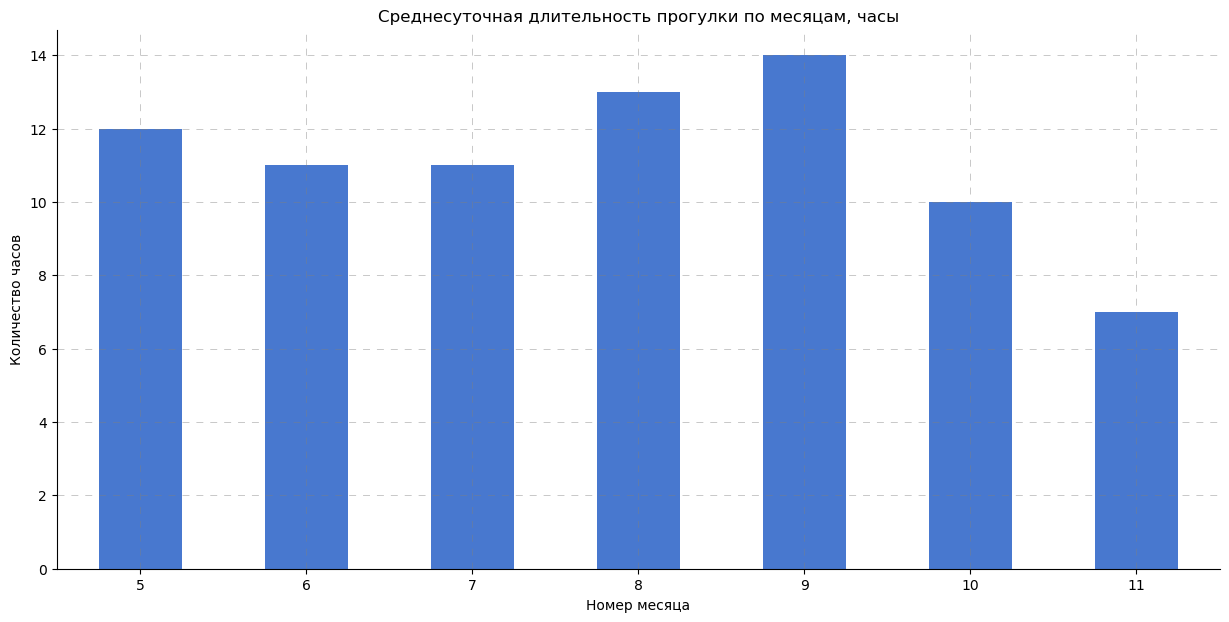

In [174]:
# столбчатая диаграмма 
data.groupby('event_month').agg({'time_diff_h': 'median'}).plot(kind = 'bar', figsize = (15, 7), legend=False)

plt.title('Среднесуточная длительность прогулки по месяцам, часы')
plt.xlabel('Номер месяца')
plt.ylabel('Количество часов')
plt.xticks(rotation = 0)

plt.grid(color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)
sns.despine()

plt.show()

Посмотрим на длительность прогулок в процентном соотношении:

In [176]:
# средняя длительность перемещений питомца за сутки по месяцам в абсолютном и процентном выражении
walk_duration = data.pivot_table(index = 'event_month', values = 'time_diff_h', aggfunc = 'median')
walk_duration.columns = ['during_of_walk']
walk_duration['% of total']= round(walk_duration['during_of_walk'] / walk_duration['during_of_walk'].sum() * 100, 0)
walk_duration

during_of_walk  % of total
event_month                            
5                      12.0        15.0
6                      11.0        14.0
7                      11.0        14.0
8                      13.0        17.0
9                      14.0        18.0
10                     10.0        13.0
11                      7.0         9.0

В среднем кошка дольше всего гуляла в сентябре и в августе (по 14 и 13 часов в сутки соответственно). В 2024 году сентябрь был нехарактерно теплым (16 °C в Павловском Посаде - ближайшем к даче городе, источник: http://www.pogodaiklimat.ru/history/27523.htm).

С октября активность питомца снижается. В ноябре средняя продолжительность прогулок сократилась с 10 до 7 часов в сутки.

На май-июнь-июль приходится по ~ 11-12 часов/сутки.

В июне и июле зафиксировано по 14 % перемещений, что ниже, чем в августе  сентябре. Возможно, Ириска действительно больше времени проводила дома. Но также это может быть связано как с тем, что кошка еще не привыкла к ошейнику и, вырываяся, убегала на улицу без него. Также некоторые члены семьи сначала 'жалели' кошку и могли выпускать на прогулку без него. Со временим к ошейнику все привыкли.

Также среди прочих причин, например, могут быть неблагоприятные погодные условия. Рассмотрим влияние погоды на длительность прогулок позже.

Учитывая, что за май зафиксировано меньше дней наблюдений, чем за ноябрь, следует отметить, что при этом на май приходится ~ в 1.5 раза больше перемещений. Можем сделать вывод, что теплые месяцы для прогулок предпочтительнее. 

Определим, в какое время дня кошка чаще выходит на улицу. Есть ли связь с временем суток? Построим распределение событий по часам:

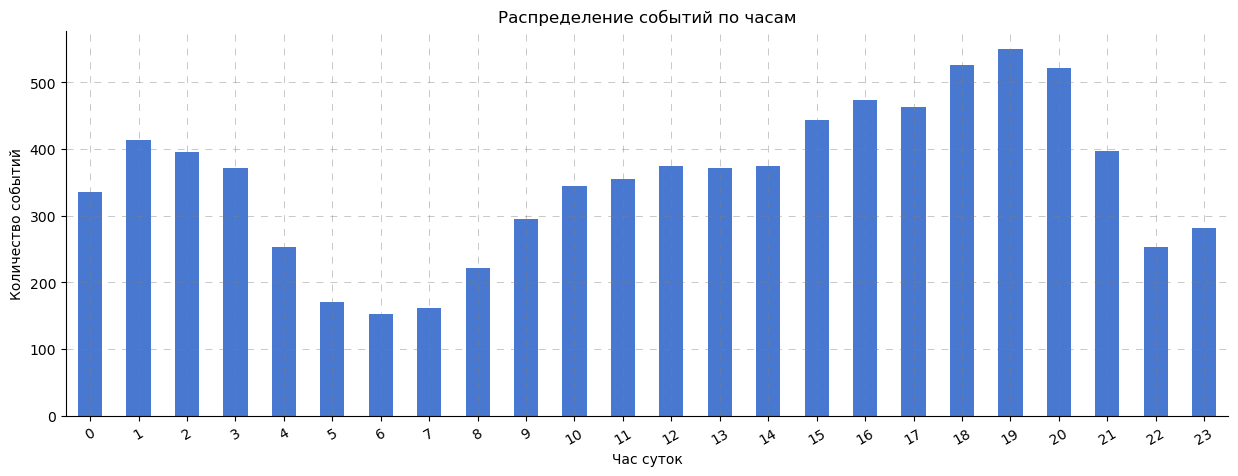

In [179]:
# столбчатая диаграмма 
data.groupby('event_hour').agg({'coordinate': 'count'}).plot(kind = 'bar', figsize = (15, 5), legend=False)

plt.title('Распределение событий по часам')
plt.xlabel('Час суток')
plt.ylabel('Количество событий')
plt.xticks(rotation = 30)

plt.grid(color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)
sns.despine()

plt.show()

Наибольшее число событий приходится на 19:00, 18:00 и 20:00. Наименее активные часы - утренние 06:00 и 07:00.

Напишем функцию, позволяющую сегментировать сутки на день, вечер, ночь и утро:

In [181]:
def part_of_all_hours(time):
    """
    Принимает на вход значение времени события столбца *event_time*
    
    Возвращает часть суток по значению времени time, используя правила:
    - 'ночь' — если время прогулки time с 00:00 до 05:59 включительно;
    - 'утро', если время прогулки time с 6:00 до 11:59 включительно;
    - 'день', если время прогулки time с 12:00 до 17:59 включительно;
    - 'вечер' — во всех остальных случаях.
    """
    
    if datetime.time(0,0,0) <= time <= datetime.time(5,59,59):
        return 'ночь'
    elif time <= datetime.time(11,59,59):
        return 'утро'
    elif time <= datetime.time(17,59,59):
        return 'день'
    else:
        return 'вечер'

In [182]:
# вызов функции part_of_all_hours с помощью apply
data['all_hours_group'] = data['event_time'].apply(part_of_all_hours)
data.sample(n=3)

coordinate          created_at type  accuracy  \
2355        55.86225, 38.65238 2024-07-09 02:54:41  gps        10   
2462  55.86251333, 38.65198333 2024-07-11 10:25:52  gps        10   
2293       55.861575, 38.65113 2024-07-07 03:45:42  gps        10   

      extra_search  direction  event_month event_date event_time  event_hour  \
2355         False        279            7 2024-07-09   02:54:41           2   
2462         False        320            7 2024-07-11   10:25:52          10   
2293         False         59            7 2024-07-07   03:45:42           3   

       latitude  longitude  time_diff_sec  time_diff_h part_of_the_world  \
2355  55.862250  38.652380        30335.0          8.0      северо-запад   
2462  55.862513  38.651983        48914.0         14.0      северо-запад   
2293  55.861575  38.651130        36581.0         10.0     северо-восток   

     all_hours_group  
2355            ночь  
2462            утро  
2293            ночь

In [183]:
# перемещения питомца утром, днем, вечером и ночью в абсолютном и процентном выражении
all_hours_moving = data.groupby('all_hours_group').agg({'coordinate': 'count'})
all_hours_moving.columns = ['count']
all_hours_moving['% of total']= round(all_hours_moving['count'] / all_hours_moving['count'].sum() * 100, 0)
all_hours_moving

count  % of total
all_hours_group                   
вечер             2528        30.0
день              2501        29.0
ночь              1939        23.0
утро              1529        18.0

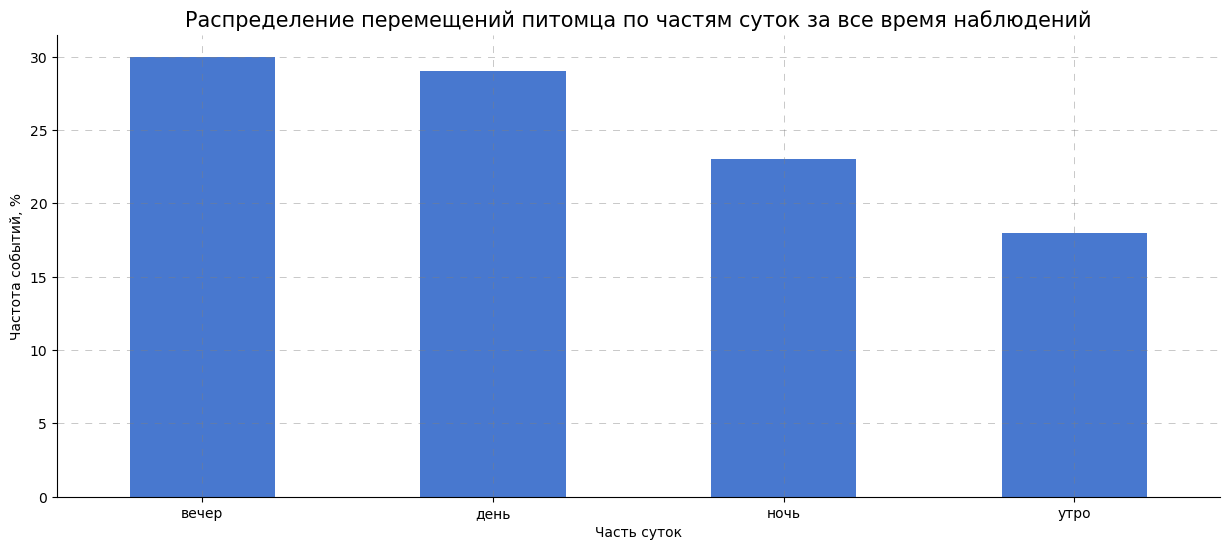

In [184]:
all_hours_moving.plot(y = '% of total', kind='bar', figsize=(15,6), legend = False)

plt.title('Распределение перемещений питомца по частям суток за все время наблюдений', fontsize=15)
plt.xlabel('Часть суток')
plt.ylabel('Частота событий, %')
plt.xticks(rotation = 0)

plt.grid(color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)
sns.despine()

plt.show()

С небольшим отрывом от дневных прогулок (29 %) лидируют вечерние - 30 %, на ночные прогулки приходится 23 % событий. Считается, что кошки наиболее активны во время сумерек и на рассвете. В целом, мой питомец скорее укладывается в общепринятую статистику, чем нет. Минимальная активность приходится на утро (с 6:00 до 11:59 включительно) - 18 %.

Проверим, зависит ли частота включения кнопки экстренного режима от времени суток:

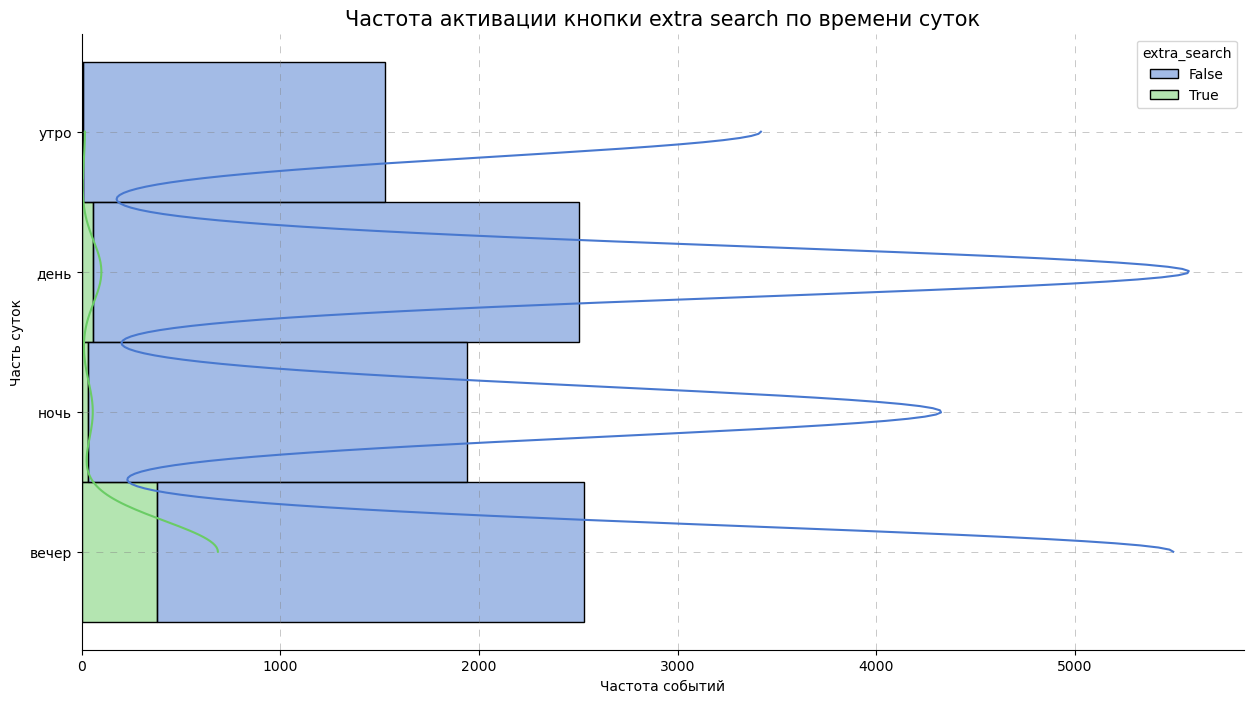

In [186]:
# распределение значений extra_search в разрезе времени суток
plt.figure(figsize=(15,8))
sns.histplot(data=data, y='all_hours_group', hue="extra_search", multiple="stack",kde=True)

plt.title('Частота активации кнопки extra search по времени суток', fontsize=15)
plt.xlabel('Частота событий')
plt.ylabel('Часть суток')
plt.xticks(rotation = 0)

plt.grid(color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)
sns.despine()

plt.show()

Посмотрим на значения в процентном соотношении:

In [188]:
# сводная таблица
all_hours_exsearch = data.pivot_table(index ='all_hours_group', columns = 'extra_search', values = 'coordinate', aggfunc = 'count')
all_hours_exsearch.columns = ['false', 'true']

# процент true от общего
all_hours_exsearch['true, %'] = round(all_hours_exsearch['true'] / (all_hours_exsearch['true'] + all_hours_exsearch['false']) * 100, 1)
all_hours_exsearch = all_hours_exsearch.fillna(0).sort_values(by = 'true, %', ascending=False)
all_hours_exsearch

false  true  true, %
all_hours_group                      
вечер             2148   380     15.0
день              2446    55      2.2
ночь              1908    31      1.6
утро              1520     9      0.6

Экстренный режим чаще активируется вечером - в 15 % от всех активаций. Яркий пример - перед сном самый поздно уходящий член семьи проверяет в мобильном приложении с помощью кнопки extra_search местоположение кошки. Зовет ее домой голосом. Если Ириска не слышит или не хочет возвращаться, она остается на улице до утра.

Ночные активации extra_search (1.6 %) совершенно точно совершала я. Из всех членов семьи только я стараюсь не допускать ситуаций, чтобы Ириска ночевала на улице:

In [190]:
# ночные поиски кошки
data.query('all_hours_group == "ночь" and extra_search == True')['event_time'].sample(3)

6800    02:00:45
8322    01:21:32
7837    03:24:54
Name: event_time, dtype: object

#### Промежуточные выводы

Процесс привыкания к ошейнику мог повлиять на результаты перемещений в июне-июле. Некоторые члены семьи иногда выпускали кошку без него. В июне и июле Ириска гуляла по ~ 11-12 часов в день.

Пик активности приходится на август и сентябрь, прогулки в среднем длились по 14 и 13 часов в сутки соответственно. С наступлением октября активность снижается, достигая к ноябрю 7 часов в сутки. Таким образом, теплые месяцы предпочтительнее для прогулок.

Питомец наиболее активен в вечерние часы (19:00, 18:00 и 20:00). 

Ириска демонстрирует типичное для кошек поведение, проявляя активность в сумерках (30 %) и наименьшую активность в утренние часы (18 %).

Чаще всего экстренный режим включается вечером перед сном.

### Влияние погодных условий на время пребывания на улице

Среди факторов влияющих на длительность прогулок вероятно есть погода. Для получения архивных данных погоды по Павловскому Посаду воспользуемся источником: https://pavlovskiy-posad.nuipogoda.ru/. 

#### Парсинг HTML

Напишем функцию, позволяющую получить двумерный массив с минимальной, максимальной погодой за сутки, а также осадки и облачность. Для реализации воспользуемся методами библиотеки BeautifulSoup, которые превращают HTML-файл в древовидную структуру. За высокую скорость в качестве парсера выбран lxml. Отыщем необходимый контент по тегам и атрибутам и преобразуем таблицу с сайта в датафрейм:

In [197]:
def temp_function(link, start_period, end_period):
    """
    Принимает на вход:
    - link - ссылка на архив погоды за конкретный месяц
    - start_period - первый день месяца
    - end_period - последний день месяца
    
    Возвращает таблицу:
    - event_date - дата в формате 'yyyy-mm-dd',
    - min_temperature - минимальная температура за сутки, °С,
    - max_temperature - максимальная температура за сутки, °С,
    - weather - характер погоды (облачность, осадки)
    """      
        
    URL = link
    req = requests.get(URL, verify=False)  # GET-запрос
    soup = BS(req.text, 'lxml')
    
    
    min_temperature = []  # Список, в котором хранятся минимальные температуры
    for row in soup.find_all(
        'span', attrs={'class': "min"} 
    ):
        min_temperature.append(row.text)
        
    max_temperature = []  # Список, в котором хранятся максимальные температуры
    for row in soup.find_all(
        'span', attrs={'class': "max"} 
    ):
        max_temperature.append(row.text)
        
    weather = []   # Список, в котором хранится характер погоды
    for row in soup.find_all(
        'div', attrs={'class': "cl_title"}
    ):
        weather.append(row.get_text(separator = ', '))  

    date = []  # Cписок, в котором хранятся даты от 1 до 30(31) дня месяца
    for row in soup.find_all(
        'div', attrs={'class': "date"}
    ):
        date.append(row.text)
    
    # Наполнение таблицы в виде двумерного массива
    temp_func = pd.DataFrame(data = {'event_date': date, 'min_temperature': min_temperature, 'max_temperature': max_temperature, 'weather': weather})

    temp_func['event_date'] = pd.period_range(start=start_period, end=end_period, freq='d')
    return temp_func

Вызовем функцию *temperatura_data* и получим архивные данные по дням для месяцев с мая по ноябрь включительно:

In [199]:
# вызов функции temp_function
may = temp_function('https://pavlovskiy-posad.nuipogoda.ru/май-2024', '2024-05-01', '2024-05-31')
june = temp_function('https://pavlovskiy-posad.nuipogoda.ru/июнь-2024', '2024-06-01', '2024-06-30')
july = temp_function('https://pavlovskiy-posad.nuipogoda.ru/июль-2024', '2024-07-01', '2024-07-31')
august = temp_function('https://pavlovskiy-posad.nuipogoda.ru/август-2024', '2024-08-01', '2024-08-31')
september = temp_function('https://pavlovskiy-posad.nuipogoda.ru/сентябрь-2024', '2024-09-01', '2024-09-30')
october = temp_function('https://pavlovskiy-posad.nuipogoda.ru/октябрь-2024', '2024-10-01', '2024-10-31')
november = temp_function('https://pavlovskiy-posad.nuipogoda.ru/ноябрь-2024', '2024-11-01', '2024-11-30')

Объединим данные в одну таблицу *temp_by_month*:

In [201]:
temp_by_month = pd.concat([may, june, july, august, september, october, november], ignore_index=True)
temp_by_month.sample(n=3)

event_date min_temperature max_temperature                weather
37   2024-06-07            +14°            +26°   облачно, без осадков
66   2024-07-06            +12°            +24°         облачно, гроза
195  2024-11-12             -1°             +0°  пасмурно, без осадков

Рассчитаем среднесуточную температуру, предварительно избавившись от символа ° и преобразовав значения в целочисленные:

In [203]:
temp_by_month = temp_by_month.replace(to_replace ='°', value = '', regex = True)

temp_by_month['avg_temp'] = round((temp_by_month['min_temperature'].astype(int) + temp_by_month['max_temperature'].astype(int)) / 2)
temp_by_month.head(3)

event_date min_temperature max_temperature                   weather  \
0  2024-05-01              +9             +20      облачно, без осадков   
1  2024-05-02              +5             +11     пасмурно, без осадков   
2  2024-05-03              -0             +10  малооблачно, без осадков   

   avg_temp  
0      14.0  
1       8.0  
2       5.0

Разобъем столбец *weather* на два столбца *clouds*, *precipitation* для дальнейшего анализа:

In [205]:
# облачность и осадки
temp_by_month[['clouds', 'precipitation']] = temp_by_month['weather'].str.split(', ', n=1, expand=True)

temp_by_month.sample(n=3)

event_date min_temperature max_temperature                weather  \
47   2024-06-17             +16             +24        пасмурно, гроза   
174  2024-10-22              +4             +12   облачно, без осадков   
161  2024-10-09              +5             +10  пасмурно, без осадков   

     avg_temp    clouds precipitation  
47       20.0  пасмурно         гроза  
174       8.0   облачно   без осадков  
161       8.0  пасмурно   без осадков

Присоединим полученную информацию к основной таблице:

In [207]:
# приведение столбца к новому формату
temp_by_month['event_date'] = temp_by_month['event_date'].dt.to_timestamp()

In [208]:
# объединение таблиц
data = data.merge(temp_by_month, on = 'event_date', how = 'left').drop(columns = ['weather'])
data.tail()

coordinate          created_at type  accuracy  \
8492       55.862185, 38.65274 2024-11-05 07:29:50  gps        10   
8493  55.86223778, 38.65325611 2024-11-05 07:39:50  gps        10   
8494  55.86276667, 38.65301833 2024-11-05 07:49:50  gps        10   
8495  55.86233611, 38.65266833 2024-11-05 07:59:51  gps        10   
8496        55.86182, 38.65254 2024-11-05 08:16:59  gps        10   

      extra_search  direction  event_month event_date event_time  event_hour  \
8492         False         23           11 2024-11-05   07:29:50           7   
8493         False         47           11 2024-11-05   07:39:50           7   
8494         False        170           11 2024-11-05   07:49:50           7   
8495         False        248           11 2024-11-05   07:59:51           7   
8496          True        114           11 2024-11-05   08:16:59           8   

      ...  longitude  time_diff_sec  time_diff_h  part_of_the_world  \
8492  ...  38.652740        26354.0          7.0      северо-восток   
8493  ...  38.653256        26354.0          7.0      северо-восток   
8494  ...  38.653018        26354.0          7.0         юго-восток   
8495  ...  38.652668        26354.0          7.0          юго-запад   
8496  ...  38.652540        26354.0          7.0         юго-восток   

     all_hours_group min_temperature max_temperature avg_temp    clouds  \
8492            утро              -2              +0     -1.0  пасмурно   
8493            утро              -2              +0     -1.0  пасмурно   
8494            утро              -2              +0     -1.0  пасмурно   
8495            утро              -2              +0     -1.0  пасмурно   
8496            утро              -2              +0     -1.0  пасмурно   

     precipitation  
8492   без осадков  
8493   без осадков  
8494   без осадков  
8495   без осадков  
8496   без осадков  

[5 rows x 21 columns]

#### Температура воздуха, осадки, облачность

Рассмотрим, как в исследуемый период изменялись метеорологические величины, такие как облачность, осадки, минимальная температура воздуха ночью и максимальная температура днем (˚С). Показатель среднесуточной температуры в Павлово-Посадском районе получен путем усреднения значений температур:

In [211]:
#  числовое описание характеристик погоды
data[['min_temperature', 'max_temperature']] = data[['min_temperature', 'max_temperature']].astype('int')
data[['min_temperature', 'max_temperature', 'avg_temp']].describe().T

count       mean       std  min   25%   50%   75%   max
min_temperature  8497.0  10.156173  5.163246 -3.0   7.0  11.0  14.0  20.0
max_temperature  8497.0  22.312699  6.984987  0.0  21.0  24.0  27.0  33.0
avg_temp         8497.0  16.274332  5.786490 -1.0  14.0  18.0  20.0  26.0

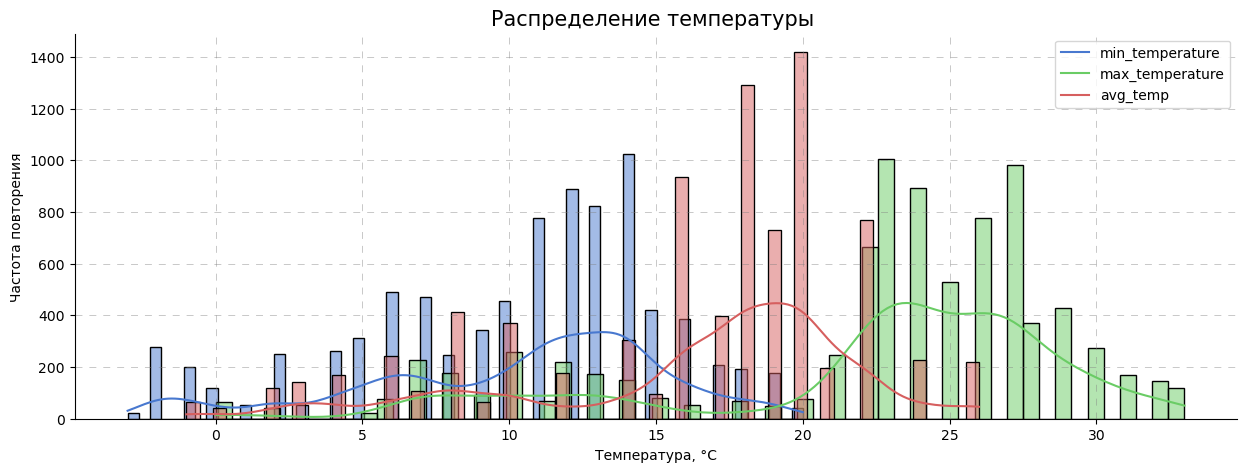

In [212]:
# распределение значений минимальной, максимальной и средней температуры
plt.figure(figsize=(15,5))
sns.histplot(data = data, x = 'min_temperature', kde = True, bins = 60)
sns.histplot(data = data, x = 'max_temperature', kde = True, bins = 60)
sns.histplot(data = data, x = 'avg_temp', kde = True, bins = 60)


plt.title('Распределение температуры ', fontsize=15)
plt.xlabel('Температура, °С')
plt.ylabel('Частота повторения')
plt.legend(['min_temperature', 'max_temperature', 'avg_temp'])

plt.grid(color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)
sns.despine() 

plt.show()

In [213]:
# средние минимальная, максимальная и средняя температура по месяцам
round(data.groupby('event_month')[['min_temperature', 'max_temperature', 'avg_temp']].agg('mean'))

min_temperature  max_temperature  avg_temp
event_month                                            
5                       10.0             27.0      19.0
6                       14.0             26.0      20.0
7                       15.0             27.0      21.0
8                       13.0             25.0      19.0
9                        8.0             23.0      16.0
10                       4.0             12.0       8.0
11                      -2.0              5.0       1.0

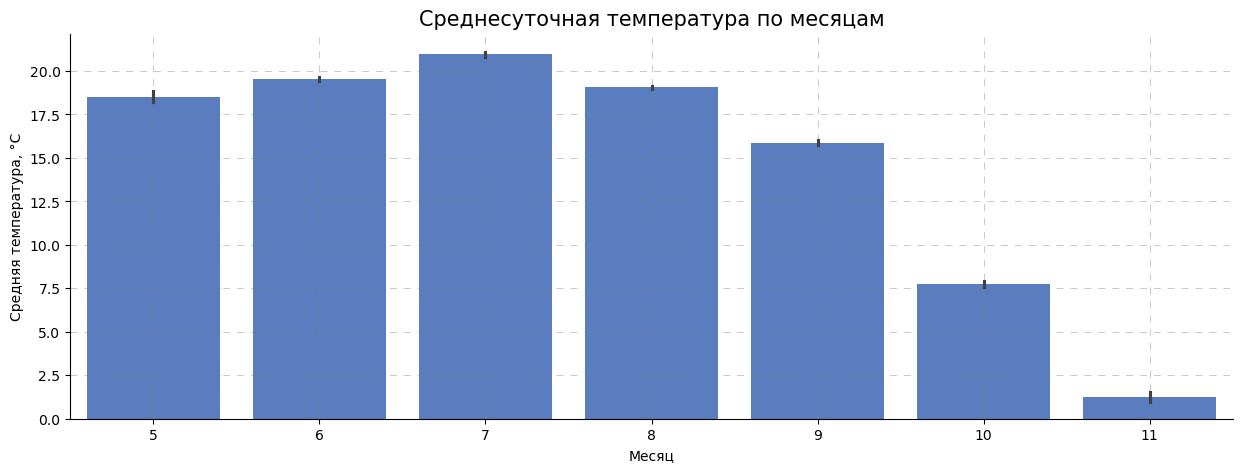

In [214]:
# изменение среднесуточной температуры по месяцам
plt.figure(figsize=(15, 5))
sns.barplot(x='event_month', y='avg_temp', data=data, estimator= 'mean')

plt.title('Среднесуточная температура по месяцам', fontsize=15)
plt.xlabel('Месяц')
plt.ylabel('Средняя температура, °С')

plt.grid(color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)
sns.despine() 

plt.show()

In [215]:
# осадки
data.groupby('precipitation')['event_date'].nunique()

precipitation
без осадков      127
гроза             27
слабые осадки      1
слабый снег        2
туман              2
Name: event_date, dtype: int64

In [216]:
# облачность
data.groupby('clouds')['event_date'].nunique()

clouds
малооблачно    29
облачно        47
пасмурно       44
ясно           39
Name: event_date, dtype: int64

В 2024 году самый жаркий месяц — июль (21 °С). Самый холодный - ожидаемо ноябрь, температура воздуха опускалась до -2 °С.

В исследуемый период осадки выпадали почти каждый пятый день. Солнечная и малооблачная погода была меньше, чем в 50 % дней.

#### Связь погодных характеристик и длительности прогулки

Теперь рассмотрим влияние характеристик погоды на длительность пребывания на улице кошки:

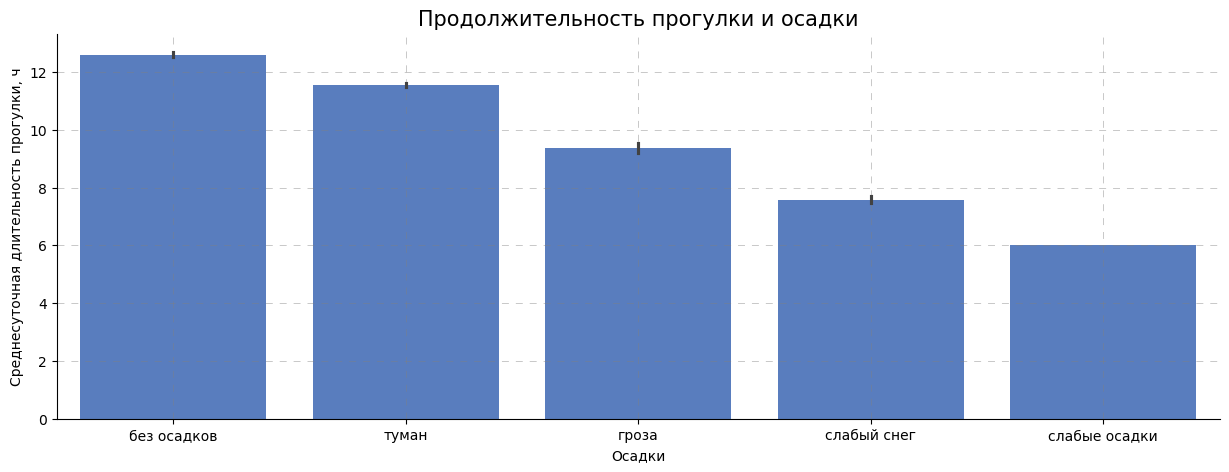

In [220]:
# осадки и длительность прогулки
plt.figure(figsize=(15,5))

order = data.groupby(['precipitation'])['time_diff_h'].mean().sort_values(ascending=False).index
sns.barplot(x='precipitation', y='time_diff_h', data=data, order=order)

plt.title('Продолжительность прогулки и осадки', fontsize=15)
plt.xlabel('Осадки')
plt.ylabel('Среднесуточная длительность прогулки, ч')
plt.xticks(rotation = 0)

plt.grid(color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)
sns.despine()

plt.show()

In [221]:
# среднесуточная длительность прогулки в зависимости от осадков, часы
round(data.groupby(['precipitation'])['time_diff_h'].mean().sort_values(ascending=False))

precipitation
без осадков      13.0
туман            12.0
гроза             9.0
слабый снег       8.0
слабые осадки     6.0
Name: time_diff_h, dtype: float64

В бездождливые дни кошка гуляет дольше — в среднем 13 часов/сутки. В случае грозы этот показатель составляет ~ 9.0 часов/сутки.

In [223]:
# распределение значений осадков в разрезе extra_search
all_hours_exsearch = data.pivot_table(index ='precipitation', columns = 'extra_search', values = 'coordinate', aggfunc = 'count')
all_hours_exsearch.columns = ['false', 'true']

# процент true от общего
all_hours_exsearch['true, %'] = round(all_hours_exsearch['true'] / (all_hours_exsearch['true'] + all_hours_exsearch['false']) * 100, 1)
all_hours_exsearch = all_hours_exsearch.fillna(0).sort_values(by = 'true, %', ascending=False)
all_hours_exsearch

false   true  true, %
precipitation                        
слабые осадки    39.0   10.0     20.4
слабый снег      66.0    6.0      8.3
без осадков    6706.0  416.0      5.8
гроза          1087.0   43.0      3.8
туман           124.0    0.0      0.0

Полученные результаты не позволяют сделать однозначных выводов. % активаций кнопки экстренного поиска вероятно не зависит от осадков на основе имеющихся данных.

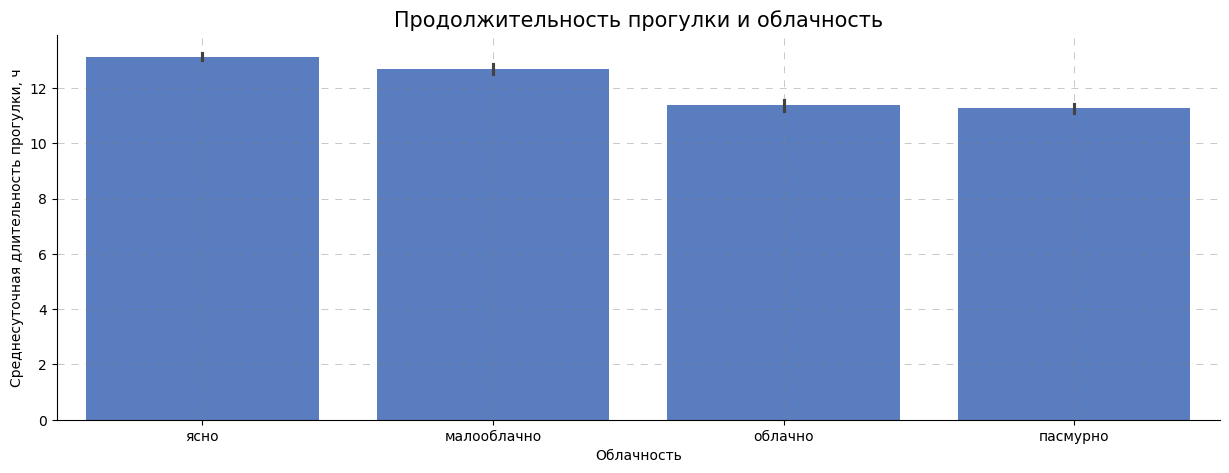

In [225]:
# облачность и длительность прогулки
plt.figure(figsize=(15,5))

order = data.groupby(['clouds'])['time_diff_h'].mean().sort_values(ascending=False).index
sns.barplot(x='clouds', y='time_diff_h',data=data, order = order)

plt.title('Продолжительность прогулки и облачность', fontsize=15)
plt.xlabel('Облачность')
plt.ylabel('Среднесуточная длительность прогулки, ч')
plt.xticks(rotation = 0)

plt.grid(color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)
sns.despine()

plt.show()

In [226]:
# среднесуточная длительность прогулки в зависимости от облачности, часы
round(data.groupby(['clouds'])['time_diff_h'].mean().sort_values(ascending=False))

clouds
ясно           13.0
малооблачно    13.0
облачно        11.0
пасмурно       11.0
Name: time_diff_h, dtype: float64

Средняя продолжительность прогулки в ясную и малооблачную погоду выше, чем в облачную и пасмурную.

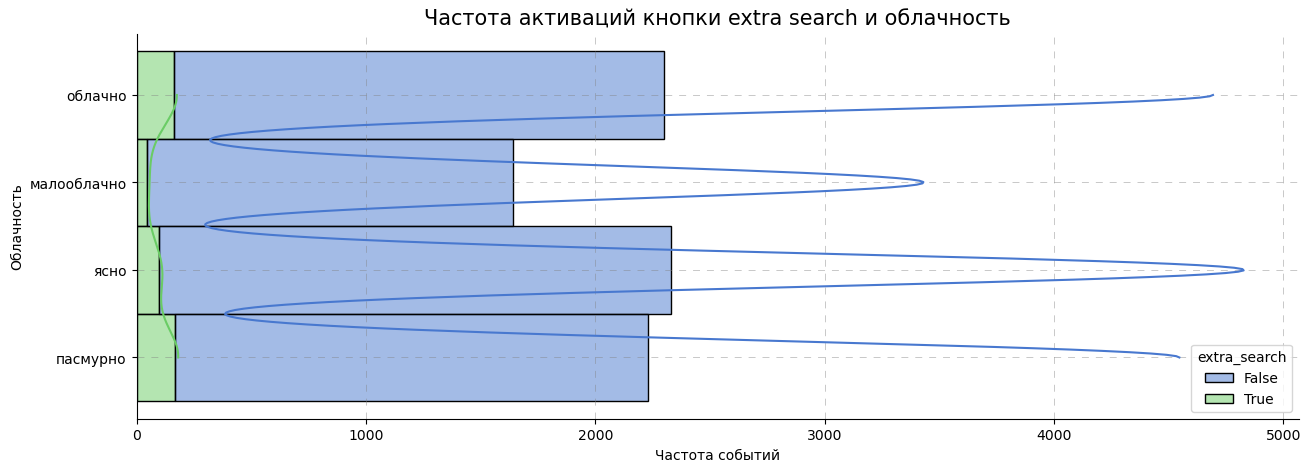

In [228]:
# распределение значений облачности в разрезе extra_search 
plt.figure(figsize=(15,5))

order = data.groupby(['clouds'])['time_diff_h'].mean().sort_values(ascending=False).index
sns.histplot(data=data, y='clouds', hue='extra_search', multiple='stack', kde=True)

plt.title('Частота активаций кнопки extra search и облачность', fontsize=15)
plt.xlabel('Частота событий')
plt.ylabel('Облачность')
plt.xticks(rotation = 0)

plt.grid(color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)
sns.despine()

plt.show()

In [229]:
# сводная таблица
all_hours_exsearch = data.pivot_table(index ='clouds', columns = 'extra_search', values = 'coordinate', aggfunc = 'count')
all_hours_exsearch.columns = ['false', 'true']

# процент true от общего
all_hours_exsearch['true, %'] = round(all_hours_exsearch['true'] / (all_hours_exsearch['true'] + all_hours_exsearch['false']) * 100, 1)
all_hours_exsearch = all_hours_exsearch.fillna(0).sort_values(by = 'true, %', ascending=False)
all_hours_exsearch

false  true  true, %
clouds                           
пасмурно      2063   167      7.5
облачно       2135   163      7.1
ясно          2229    99      4.3
малооблачно   1595    46      2.8

В пасмурную и облачную погоду кнопку extra_search активировали чаще.

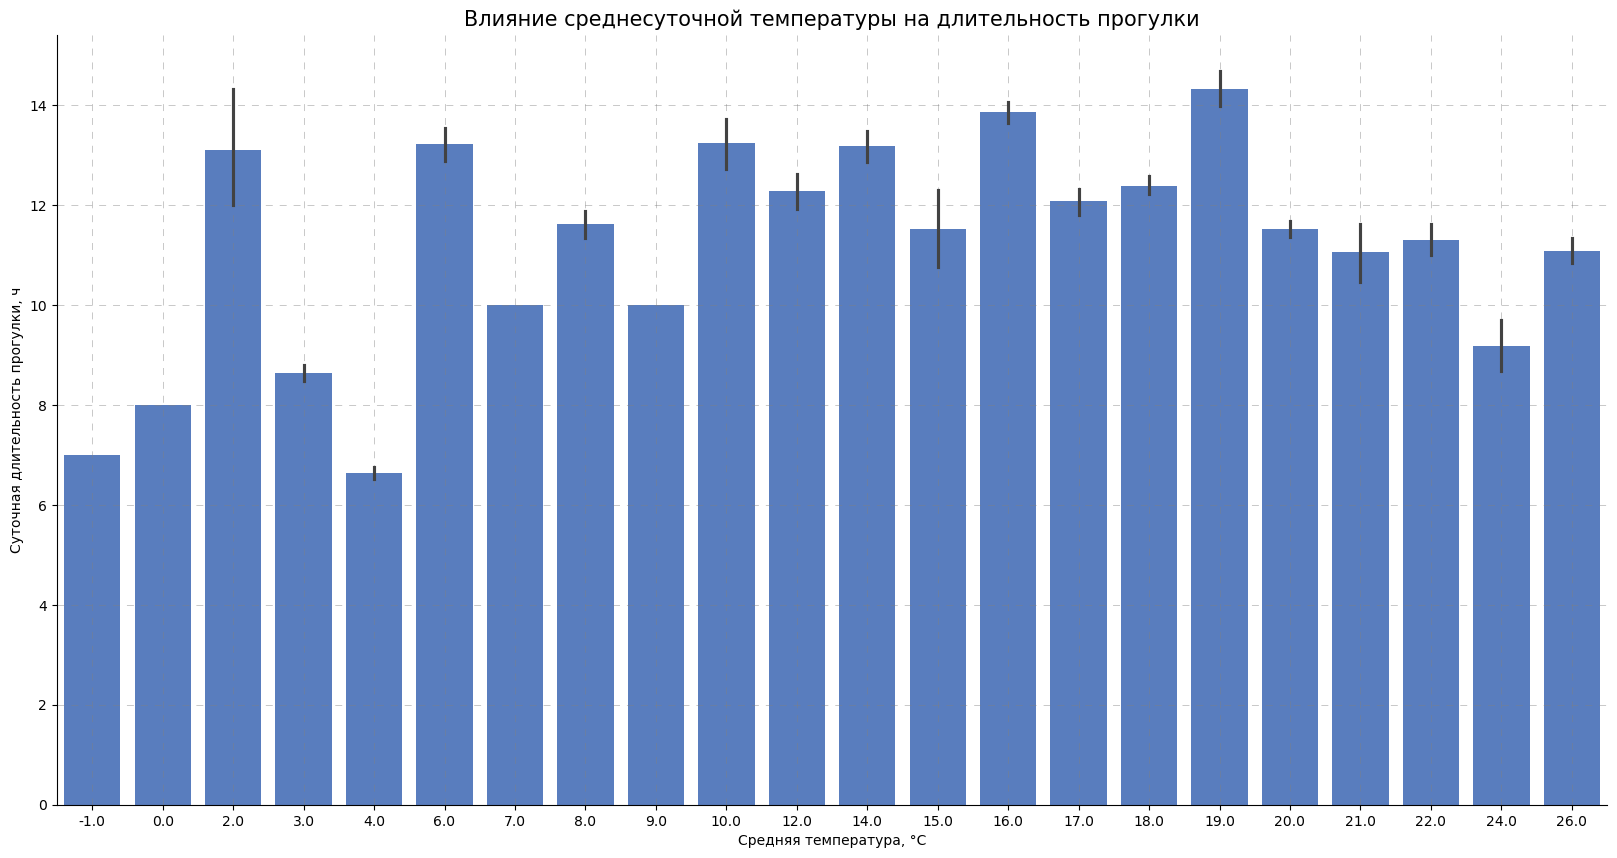

In [231]:
# среднесуточная температура воздуха и длительность прогулки
plt.figure(figsize=(20,10))
ax = sns.barplot(x='avg_temp', y='time_diff_h', data=data, estimator= 'mean')

plt.title('Влияние среднесуточной температуры на длительность прогулки', fontsize=15)
plt.xlabel('Средняя температура, °С')
plt.ylabel('Суточная длительность прогулки, ч')

plt.grid(color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)
sns.despine() 

plt.show()

В среднем время пребывания на улице выше при более высоких температурах воздуха.

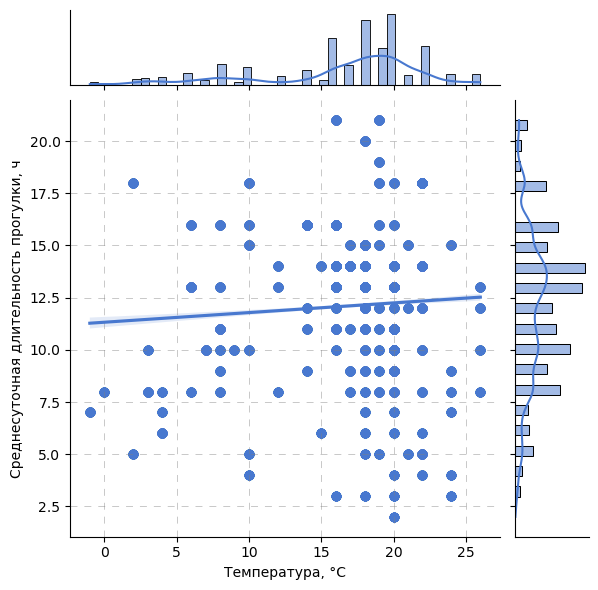

In [233]:
# совместное распределение - среднесуточная длительность прогулки и среднесуточная температура
sns.jointplot(x='avg_temp', y='time_diff_h', data=data, kind='reg')

plt.xlabel('Температура, °С')
plt.ylabel('Среднесуточная длительность прогулки, ч')
plt.xticks(rotation = 0)

plt.grid(color="gray", linestyle=(0, (10, 10)), linewidth=0.5, alpha=0.6)
sns.despine()

plt.show()

Между температурой воздуха и продолжительностью прогулки линейная связь отсутствует.

Для определения взаимосвязи между несколькими величинами рассчитаем коэффициенты корреляции. Так как в данных содержатся  переменные со смешанными типами воспользуемся коэффициентом φK (PhiK). 

Он позволяет зафиксировать нелинейную зависимость, а также возвращается к коэффициенту корреляции Пирсона в случае двумерного нормального распределения входных данных [https://arxiv.org/pdf/1811.11440 ].

In [235]:
# копия датасета
data_copy = data.copy()

# удаление из копии лишних данных
data_copy.drop(columns = ['coordinate', 'type', 'accuracy', 'created_at', 'event_hour', 'time_diff_sec', 'part_of_the_world', 'event_date','event_time', 'min_temperature', 'max_temperature'], axis=1, inplace=True)
data_copy.sample()

extra_search  direction  event_month   latitude  longitude  time_diff_h  \
5604         False        106            9  55.862152  38.652378         15.0   

     all_hours_group  avg_temp clouds precipitation  
5604           вечер      17.0   ясно   без осадков

Несмотря на то, что типы переменных могут быть определены phik-пакетом автоматически, укажем их самостоятельно:

In [237]:
# типы переменных
data_types = {'extra_search': 'categorical',  # категориальный номинальный (без иерархии)
             'direction':'interval',
             'event_month':'interval',        # числовой дискретный
             'all_hours_group':'categorical',
             'latitude':'interval',          
             'longitude':'interval',
             'time_diff_h':'interval',        # числовой непрерывный
             'avg_temp':'interval',
             'clouds': 'categorical',
             'precipitation': 'categorical'}

Для вычисления phik-корреляции и значимости переменные числового типа необходимо сгруппировать, для этого создадим список интервальных переменных:

In [239]:
# список числовых переменных
interval_cols = [col for col, v in data_types.items() if v=='interval' and col in data.columns]
interval_cols

['direction',
 'event_month',
 'latitude',
 'longitude',
 'time_diff_h',
 'avg_temp']

Вычислим коэффициенты корреляции между парами переменных. Визуализируем результаты матрицы корреляции в виде тепловой карты:

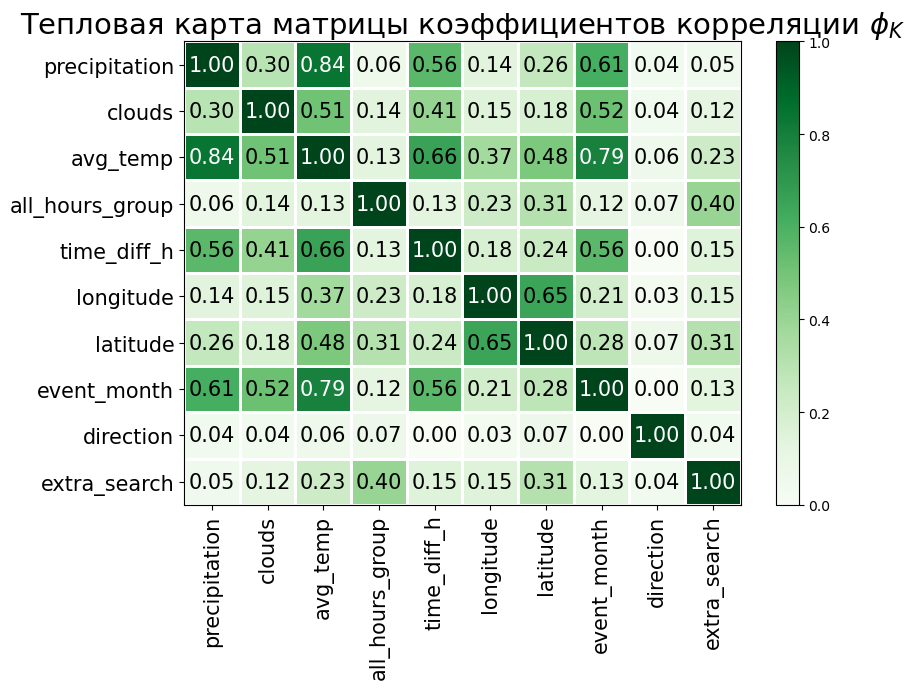

In [241]:
# матрица корреляции phik между всеми переменными
phik_overview = round(data_copy.phik_matrix(interval_cols=interval_cols),2)

# тепловая карта
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Тепловая карта матрицы коэффициентов корреляции $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(9, 7))
plt.tight_layout()

Пары с наиболее сильной корреляцией: 
- *средняя температура* и *осадки* - 0.81
- *средняя температура* и *месяц* - 0.78.

Однако, нас в первую очередь интересуют переменные, напрямую относящиеся к действиям кошки.

Можно отметить, что существует некоторая корреляция между переменными:
- *среднесуточное время пребывания на улице* и *средняя температура* - 0.69
- *долгота* и *широта* - 0.65
- *среднесуточное время пребывания на улице* и *осадки* - 0.56
- *среднесуточное время пребывания на улице* и *месяц* - 0.56
- *широта* и *средняя температура* - 0.49
- *extra_search* и *время суток* - 0.40

*direction (направление)* не коррелирует ни с одной переменной.


Отобразим глобальные коэффициенты корреляции - это показатель общей корреляции одной переменной со всеми другими переменными в наборе данных:

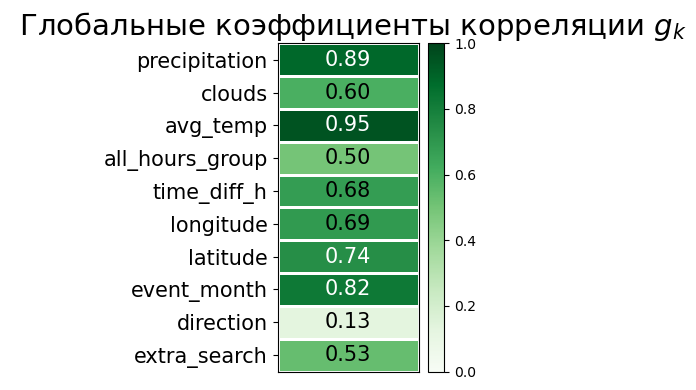

In [244]:
# глобальные коэффициенты корреляции
global_correlation, global_labels = data_copy.global_phik(interval_cols=interval_cols)

plot_correlation_matrix(global_correlation, 
                        x_labels=[''],
                        y_labels=global_labels,
                        vmin=0, vmax=1,
                        figsize=(4,4),
                        color_map="Greens",
                        title=r" Глобальные коэффициенты корреляции $g_k$",
                        fontsize_factor=1.5,)
plt.tight_layout()

Все переменные, кроме *direction* имеют достаточно высокие значения глобального показателя корреляции.

Наибольшие значения приходятся на *среднюю температуру*, *осадки* и *месяц*. Высокие значения обусловлены сильной корреляцией этих переменных с остальными показателями.

При оценке корреляций всегда следует смотреть не только на коэффициенты, но и на их статистическую значимость. Потому что, высокий коэффициент корреляции может оказаться статистически незначимым, и наоборот.

Построим матрицу, показывающую статистическую значимость пар коррелированных и некоррелированных переменных:

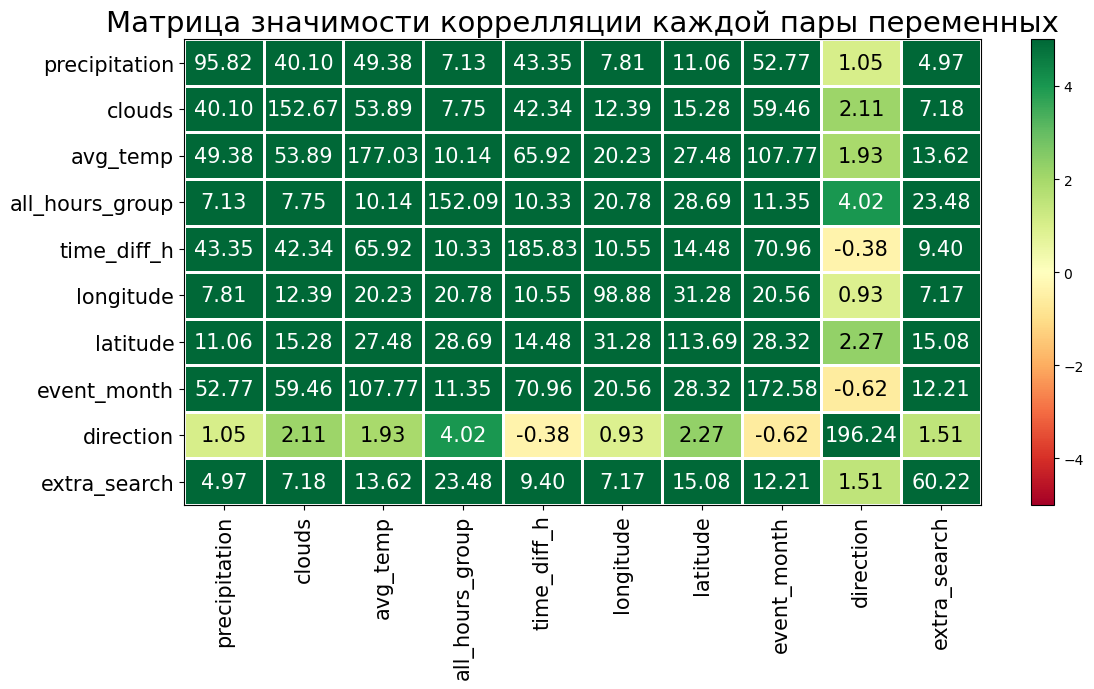

In [247]:
# матрица значимости (выраженная как одностор. z-тест) проверки гипотезы зависимости каждой пары переменных:
significance_overview = data_copy.significance_matrix(interval_cols=interval_cols)

plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5,                             # ±5 станд.откл
                        title="Матрица значимости коррелляции каждой пары переменных", 
                        usetex=False,
                        fontsize_factor=1.5, figsize=(12, 7))
plt.tight_layout()

Относительно высокие значения коэффициента корреляции φK между переменными, указанными выше, являются статистически значимыми. 

Все, что относится к *direction (направление)*, не является статистически значимым.

Теперь проверим конкретные взаимосвязи между переменными. Рассмотрим непрерывный и категориальный признаки:

interval columns not set, guessing: ['time_diff_h']


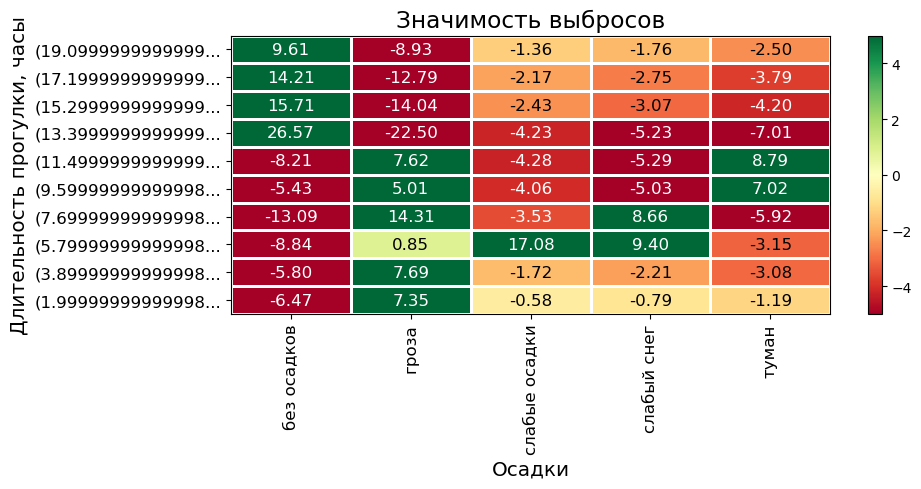

In [250]:
c1 = 'precipitation'  # осадки - категориальный
c0 = 'time_diff_h'    # среднесуточное время пребывания на улице

outlier_signifs, binning_dict = data_copy[[c0,c1]].outlier_significance_matrix(retbins=True)

zvalues = outlier_signifs.values
xlabels = binning_dict[c1] if c1 in binning_dict.keys() else outlier_signifs.columns
ylabels = binning_dict[c0] if c0 in binning_dict.keys() else outlier_signifs.index

plot_correlation_matrix(zvalues,
                        x_labels=xlabels,
                        y_labels=ylabels, 
                        x_label='Осадки',
                        y_label='Длительность прогулки, часы',
                        vmin=-5,
                        vmax=5,
                        title='Значимость выбросов',
                        identity_layout=False,
                        fontsize_factor=1.2,
                        figsize=(10, 5))

То, что переменная *среднесуточное время пребывания на улице* непрерывная, phik-пакет в данном случае определил самостоятельно.

Выводы, которые можно сделать: кошка гуляет дольше в дни без осадков. 

Посмотрим теперь на пару категориальных переменных:

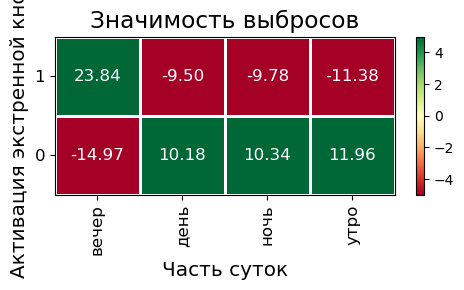

In [252]:
c1 = 'all_hours_group'  # время суток
c0 = 'extra_search'     # кнопка экстра поиска


outlier_signifs, binning_dict = data_copy[[c0,c1]].outlier_significance_matrix(retbins=True)

zvalues = outlier_signifs.values
xlabels = binning_dict[c1] if c1 in binning_dict.keys() else outlier_signifs.columns
ylabels = binning_dict[c0] if c0 in binning_dict.keys() else outlier_signifs.index


plot_correlation_matrix(zvalues,
                        x_labels=xlabels,
                        y_labels=ylabels, 
                        x_label='Часть суток',
                        y_label='Активация экстренной кнопки',
                        vmin=-5,
                        vmax=5,
                        title='Значимость выбросов',
                        identity_layout=False,
                        fontsize_factor=1.2,
                        figsize=(5, 3))

Включение кнопки экстренного поиска больше характерно для вечернего времени суток.

Посмотрим теперь на пару непрерывных переменных:

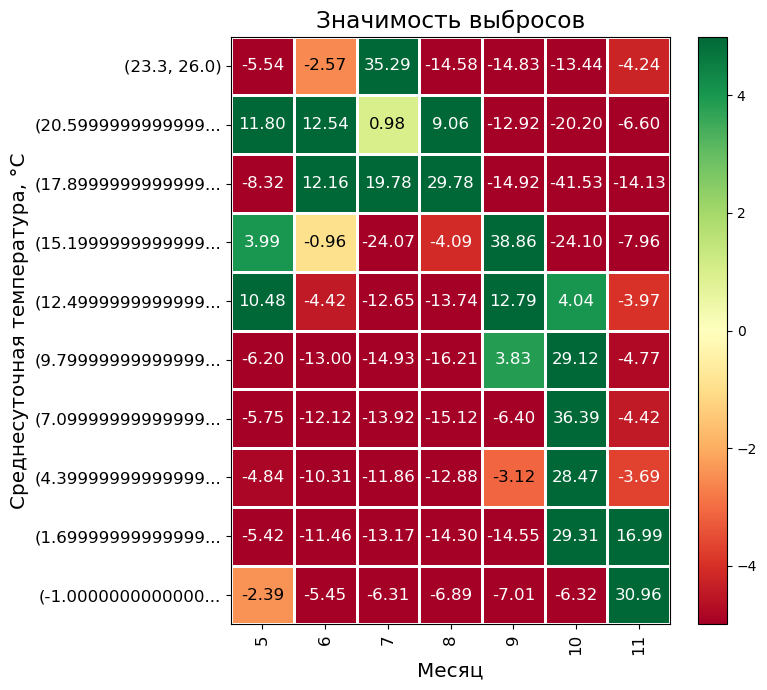

In [254]:
c1 = 'event_month'  # время суток
c0 = 'avg_temp'     # кнопка экстра поиска

tmp_interval_cols = ['avg_temp']

outlier_signifs, binning_dict = data_copy[[c0,c1]].outlier_significance_matrix(interval_cols=tmp_interval_cols, retbins=True)

zvalues = outlier_signifs.values
xlabels = binning_dict[c1] if c1 in binning_dict.keys() else outlier_signifs.columns
ylabels = binning_dict[c0] if c0 in binning_dict.keys() else outlier_signifs.index
xlabel = c1
ylabel = c0

plot_correlation_matrix(zvalues,
                        x_labels=xlabels,
                        y_labels=ylabels, 
                        x_label='Месяц',
                        y_label='Среднесуточная температура, °С',
                        vmin=-5,
                        vmax=5,
                        title='Значимость выбросов',
                        identity_layout=False,
                        fontsize_factor=1.2,
                        figsize=(8, 7))

Среднесуточная температура -2 °С больше характерна для ноября, а не для октября или мая. В августе было холоднее, чем в июле. 
То есть, среднемесячная температура изменяется по ожидаемым сезонным закономерностям. 

Аналогичный результат подтверждается диаграммой рассеивания:

In [256]:
# диаграмма рассеивания 
scatter = px.scatter(data_copy, x='avg_temp', y='event_month', trendline="ols", trendline_color_override="red")
scatter.update_xaxes(showgrid=False)
scatter.update_yaxes(showgrid=False)
scatter.update_layout(plot_bgcolor='white')
scatter.show()

#### Промежуточные выводы

Получен двумерный массив с минимальной, максимальной погодой за сутки, а также осадки и облачность. Рассчитана среднесуточная температура за исследуемый период.

Выявленные нелинейные связи, относящиеся к действиям Ириски:

- кошка гуляет дольше в дни без осадков;
- кошка предпочитает для прогулок более теплые мясяцы;
- включение кнопки экстренного поиска больше характерно для вечернего времени суток.

## Дополнительные расчеты

В таблице не представлены данные скорости питомца и пройденного расстояния, однако, эта информация отображается в мобильном приложении. Учтем эти результаты для полноты исследования:

<img src="IMG_7807.png" style="width:300px;height: 700px"> 

Максимальная скорость Ириски ~ 49 км/час. Различные источники в интернете подтверждают, что домашние кошки способны развивать такую скорость в рывке и на недлинных дистанциях.

Средняя скорость питомца ~ 0.30 км/час.

<img src="IMG_7966.png" style="width:300px;height: 700px"> 

С мая 2024 по март 2025 она прошла ~ 666 км (с учетом велопоездки 26.08.2024):

<img src="IMG_7809.png" style="width:300px;height: 700px"> 

По количеству пройденных километров в разрезе месяцев можем сделать вывод о том, что в зимние месяцы кошка менее активна (скрины не приводятся для экономии места). Наблюдения за питомцем это подтверждают: зимой большую часть суток Ириска провела дома во сне. В прошлую зиму поведение кошки было аналогично.

Таким образом, в среднем кошка проходит по 4.2 км/сутки.

<img src="IMG_7825.png" style="width:300px;height: 700px"> 

## Выводы

В ходе анализа GPS-данных перемещений кошки Ириски выявлены ключевые закономерности в её активности, предпочтениях маршрутов, а также связи с погодными условиями и использованием экстренного режима.

🐾 **Общая активность питомца:**

✔ Кошка активно исследует территорию, но не придерживается строгих маршрутов;

✔ Среднее время на улице ~ 11 часов в сутки;

✔ Пик активности пришёлся на август (14 часов/сутки), минимальная активность достигнута в ноябре (7 часов/сутки). Таким образом, теплые месяцы предпочтительнее для прогулок;

✔ Наибольшее число перемещений фиксируется в вечернее время (30 % прогулок в сумерках) и наименьшее в утренние часы (18 %). Ириска демонстрирует типичное поведение для кошек;

✔ Ночью кошка остаётся на улице в 18 % случаев.

🐾 **Анализ маршрутов и территории прогулок:**

✔ Среднесуточная дистанция — 4.2 км;

✔ Основная зона прогулок ~ 55.861 - 55.863 / ~ 38.65 - 38.655 (зона с наибольшей плотностью точек);

✔ Площадь территории прогулок ~ 1.5 км^2;

✔ С сентября кошка стала уходить дальше от дома, за границы привычной территории;

✔ Максимальное геодезическое расстояние между крайними точками маршрутов ~ 2.0 км (север-юг) и 1.6 км (запад-восток);

✔ Любимые места — домашний участок и двор соседей.

🐾 **Влияние внешних факторов (погода, температура):**

✔ Среднее время прогулки в бездождливые дни — 13 часов/сутки, в дождливые — 9 часов/сутки;

✔ Осадки уменьшают общую активность кошки на 30.0 %;

✔ В ясную и малооблачную погоду длительность прогулок немного выше, чем в облачную и пасмурную.


🐾 **Использование экстренного режима:**

✔ Экстренный режим включался 475 раз (5.6 % от всех записей);

✔ Пик включений в октябре — 39 % (184 раз);

✔ Чаще всего экстренный режим активируется вечером (15 % случаев);

✔ Ночная активность питомца повышает вероятность активации экстренного режима.


🐾 **Пути развития исследования:**

✔ Оценить влияние скорости и направления ветра;

✔ Выделить любимые зоны кошки (кластеризация мест прогулок, K-Means) после накопления большего объема данных;

✔ Сравнить маршруты нескольких питомцев.

<img src="IMG_7582.jpg" style="width:550px;height: 700px"> 